# 🍌 Predicción de Precio Spot de Banano Ecuatoriano

## 🎯 Objetivo Principal
Predecir el **Precio Spot de Banano** utilizando:
- **Variable principal**: Enfunde de Ecuador (total y por provincias)
- **Variables adicionales**: Enfunde de Colombia y Costa Rica
- **Variables climáticas**: Temperatura, precipitaciones, radiación solar, humedad
- **Features temporales**: Tendencias, estacionalidad, lags

## 📊 Enfoque Analítico
1. **EDA centrado en Precio Spot** como variable objetivo
2. **Análisis de correlaciones** y desfases temporales (lags)
3. **Feature Engineering** para capturar relaciones complejas
4. **Modelos multivariados** que incorporen enfunde de múltiples países
5. **Feature Importance** para identificar predictores clave

## 🤖 Modelos a Evaluar
1. Regresión Lineal/Ridge/Lasso
2. Random Forest
3. XGBoost/LightGBM
4. LSTM (Series Temporales Multivariadas)
5. Prophet con regresores adicionales

## 📈 Métricas
- RMSE, MAE, MAPE, R²

---
## 📦 1. Instalación y Configuración

In [ ]:
# Instalar librerías
!pip install -q openpyxl pandas numpy matplotlib seaborn scikit-learn statsmodels
!pip install -q prophet xgboost lightgbm tensorflow pmdarima

print("✅ Librerías instaladas")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.0 MB/s eta 0:00:00
✅ Librerías instaladas


In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías importadas")

✅ Librerías importadas


---
## 📁 2. Carga de Datos

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta de los archivos
ruta = '/content/drive/MyDrive/PRECIO SPOT BANANO/'

Mounted at /content/drive


In [ ]:
# Cargar todos los datasets
df_colombia = pd.read_excel(ruta + 'Enfunde_Colombia_Historico.xlsx')
df_costa_rica = pd.read_excel(ruta + 'Enfunde_Costa_Rica_Historico.xlsx')
df_ecuador = pd.read_excel(ruta + 'Enfunde_Ecuador_Historico.xlsx')
df_precios = pd.read_excel(ruta + 'Precios_Spot_Banano.xlsx')
df_clima = pd.read_excel(ruta + 'Datos_Clima_Historico.xlsx')

print("✅ Datos cargados")
print(f"\nDimensiones:")
print(f"Ecuador: {df_ecuador.shape} (PRINCIPAL)")
print(f"Colombia: {df_colombia.shape}")
print(f"Costa Rica: {df_costa_rica.shape}")
print(f"Precios (OBJETIVO): {df_precios.shape}")
print(f"Clima: {df_clima.shape}")

✅ Datos cargados

Dimensiones:
Ecuador: (206, 6) (PRINCIPAL)
Colombia: (205, 3)
Costa Rica: (204, 3)
Precios (OBJETIVO): (257, 3)
Clima: (132, 6)


---
## 🔧 3. Preparación de Datos

In [ ]:
# Función para crear fechas
def crear_fecha(row):
    year = int(row['Año'])
    week = int(row['Semana'])
    first_day = datetime(year, 1, 1)
    days_to_week = (week - 1) * 7
    return first_day + timedelta(days=days_to_week)

# Aplicar a todos los datasets
for df in [df_colombia, df_costa_rica, df_ecuador, df_precios, df_clima]:
    df['Fecha'] = df.apply(crear_fecha, axis=1)
    df.sort_values('Fecha', inplace=True)
    df.reset_index(drop=True, inplace=True)

# Limpiar precios (convertir de string a float)
df_precios['Precio'] = df_precios['Precio'].astype(str).str.replace(',', '.').astype(float)

print("✅ Fechas creadas y datos ordenados")
print(f"\nRango de fechas Precios: {df_precios['Fecha'].min()} a {df_precios['Fecha'].max()}")
print(f"Rango de fechas Ecuador: {df_ecuador['Fecha'].min()} a {df_ecuador['Fecha'].max()}")

✅ Fechas creadas y datos ordenados

Rango de fechas Precios: 2021-01-01 00:00:00 a 2025-12-10 00:00:00
Rango de fechas Ecuador: 2022-01-01 00:00:00 a 2025-12-10 00:00:00


In [ ]:
# Renombrar columnas para claridad
df_colombia = df_colombia.rename(columns={'Enfunde': 'Enfunde_Colombia'})
df_costa_rica = df_costa_rica.rename(columns={'Enfunde': 'Enfunde_CostaRica'})
df_ecuador = df_ecuador.rename(columns={
    'Ecuador': 'Enfunde_Ecuador',
    'Los Rios': 'Enfunde_LosRios',
    'Guayas': 'Enfunde_Guayas',
    'El Oro': 'Enfunde_ElOro'
})

print("✅ Columnas renombradas")

✅ Columnas renombradas


### 3.1 Crear Dataset Consolidado

In [ ]:
# Unir todos los datos por fecha
# Empezamos con Precios (variable objetivo)
df_master = df_precios[['Fecha', 'Precio']].copy()

# Agregar enfunde Ecuador
df_master = df_master.merge(
    df_ecuador[['Fecha', 'Enfunde_Ecuador', 'Enfunde_LosRios', 'Enfunde_Guayas', 'Enfunde_ElOro']],
    on='Fecha', how='left'
)

# Agregar enfunde Colombia
df_master = df_master.merge(
    df_colombia[['Fecha', 'Enfunde_Colombia']],
    on='Fecha', how='left'
)

# Agregar enfunde Costa Rica
df_master = df_master.merge(
    df_costa_rica[['Fecha', 'Enfunde_CostaRica']],
    on='Fecha', how='left'
)

# Agregar datos climáticos
df_master = df_master.merge(
    df_clima[['Fecha', 'Temperatura', 'Precipitaciones', 'Radiación Solar', 'Humedad']],
    on='Fecha', how='left'
)

print(f"✅ Dataset consolidado creado: {df_master.shape}")
print(f"\nPrimeras filas:")
print(df_master.head(10))
print(f"\nÚltimas filas:")
print(df_master.tail(10))

✅ Dataset consolidado creado: (257, 12)

Primeras filas:
       Fecha  Precio  Enfunde_Ecuador  Enfunde_LosRios  Enfunde_Guayas  \
0 2021-01-01    7.04              NaN              NaN             NaN   
1 2021-01-08    7.24              NaN              NaN             NaN   
2 2021-01-15    7.61              NaN              NaN             NaN   
3 2021-01-22    9.00              NaN              NaN             NaN   
4 2021-01-29   10.21              NaN              NaN             NaN   
5 2021-02-05   10.14              NaN              NaN             NaN   
6 2021-02-12    9.68              NaN              NaN             NaN   
7 2021-02-19    9.14              NaN              NaN             NaN   
8 2021-02-26   10.00              NaN              NaN             NaN   
9 2021-03-05    9.75              NaN              NaN             NaN   

   Enfunde_ElOro  Enfunde_Colombia  Enfunde_CostaRica  Temperatura  \
0            NaN               NaN                NaN     

In [ ]:
# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(df_master.isnull().sum())
print(f"\nPorcentaje de completitud:")
print((1 - df_master.isnull().sum() / len(df_master)) * 100)


Valores faltantes por columna:
Fecha                  0
Precio                 0
Enfunde_Ecuador       52
Enfunde_LosRios       52
Enfunde_Guayas        52
Enfunde_ElOro         52
Enfunde_Colombia      53
Enfunde_CostaRica     54
Temperatura          126
Precipitaciones      126
Radiación Solar      126
Humedad              126
dtype: int64

Porcentaje de completitud:
Fecha                100.000000
Precio               100.000000
Enfunde_Ecuador       79.766537
Enfunde_LosRios       79.766537
Enfunde_Guayas        79.766537
Enfunde_ElOro         79.766537
Enfunde_Colombia      79.377432
Enfunde_CostaRica     78.988327
Temperatura           50.972763
Precipitaciones       50.972763
Radiación Solar       50.972763
Humedad               50.972763
dtype: float64


In [ ]:
df_master.to_excel("data_master_ml.xlsx")

---
## 📊 4. Análisis Exploratorio - Precio Spot (Variable Objetivo)

In [ ]:
# Estadísticas del Precio Spot
print("="*80)
print("ANÁLISIS DE PRECIO SPOT - VARIABLE OBJETIVO")
print("="*80)
print(f"\nPeríodo: {df_master['Fecha'].min()} a {df_master['Fecha'].max()}")
print(f"Total observaciones: {len(df_master)}")
print(f"\nEstadísticas:")
print(df_master['Precio'].describe())
print(f"\nVolatilidad (CV): {(df_master['Precio'].std() / df_master['Precio'].mean()) * 100:.2f}%")

ANÁLISIS DE PRECIO SPOT - VARIABLE OBJETIVO

Período: 2021-01-01 00:00:00 a 2025-12-10 00:00:00
Total observaciones: 257

Estadísticas:
count    257.000000
mean       7.458911
std        2.636623
min        2.000000
25%        5.760000
50%        7.220000
75%        9.650000
max       13.260000
Name: Precio, dtype: float64

Volatilidad (CV): 35.35%


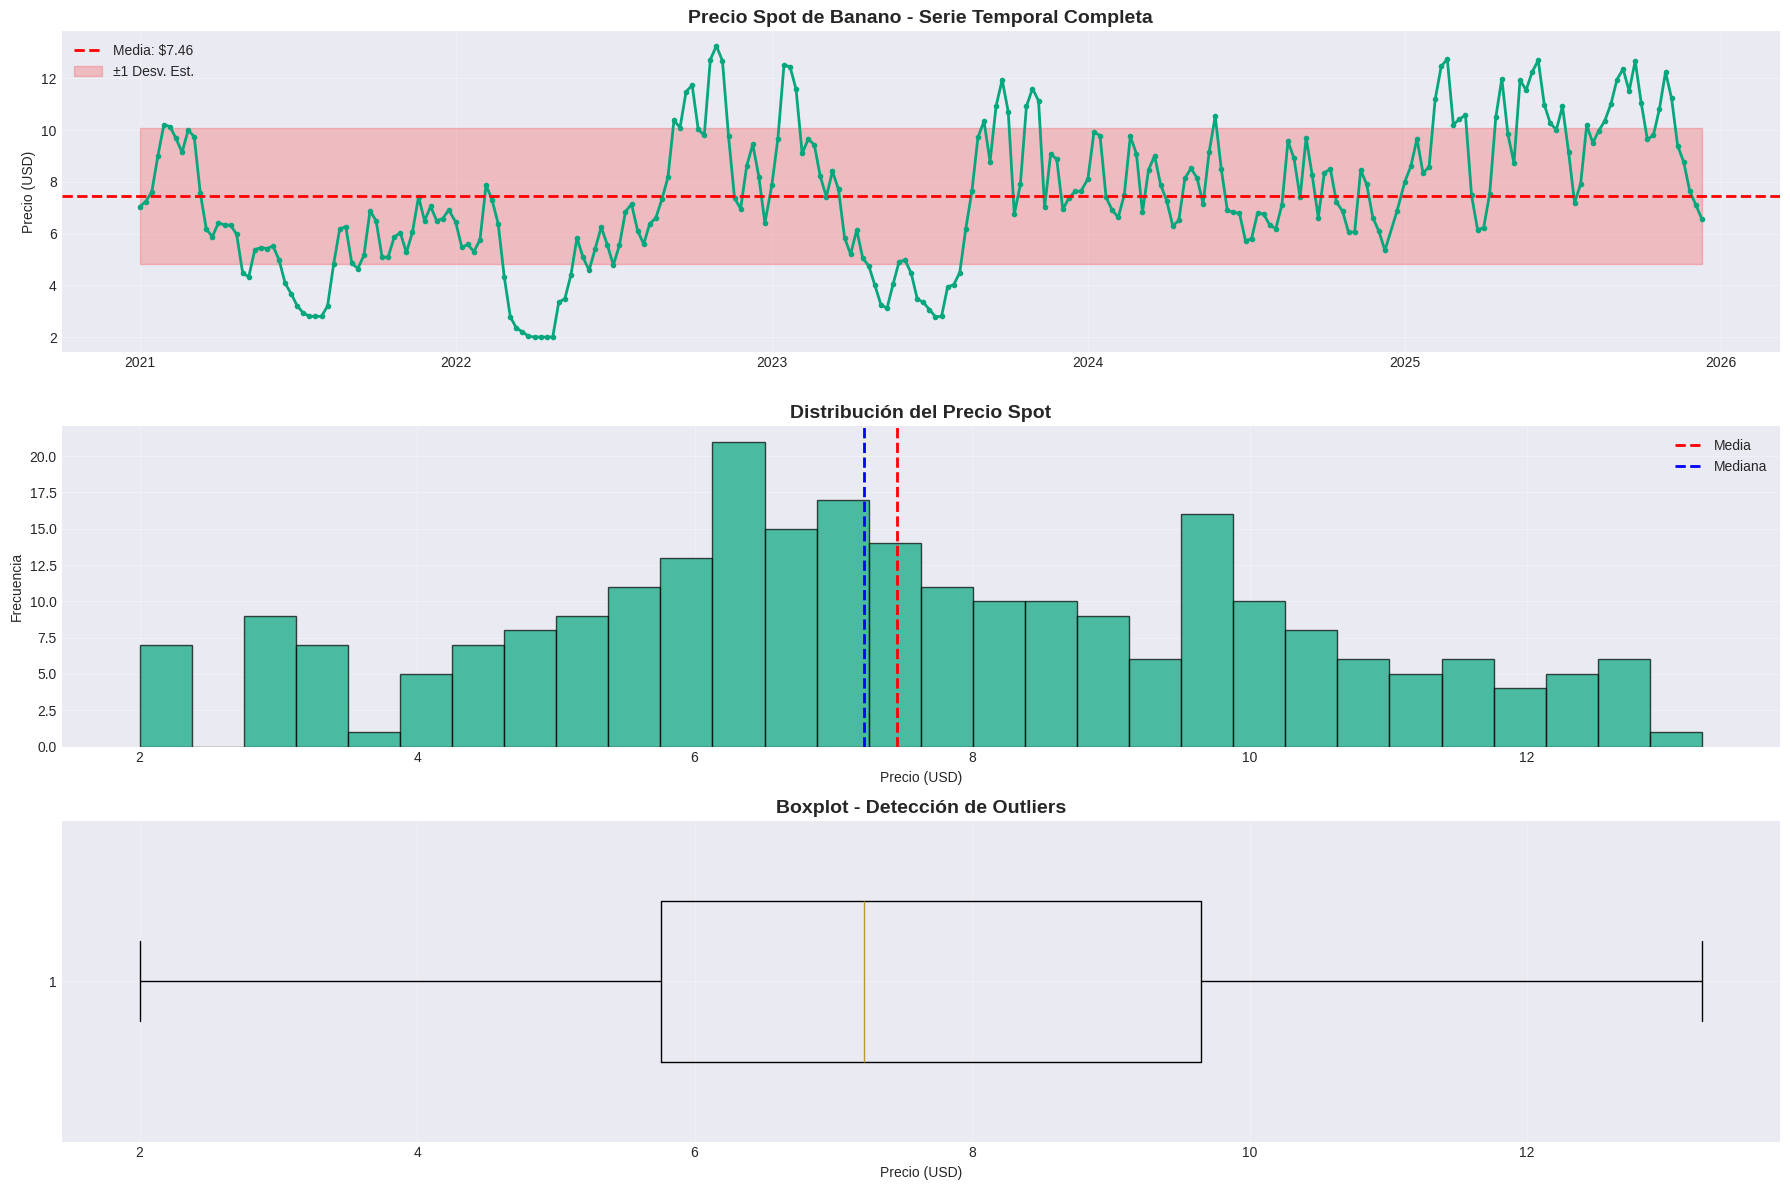

In [ ]:
# Visualización del Precio Spot
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Serie temporal
axes[0].plot(df_master['Fecha'], df_master['Precio'], linewidth=2, color='#06A77D', marker='o', markersize=3)
axes[0].axhline(df_master['Precio'].mean(), color='red', linestyle='--', label=f'Media: ${df_master["Precio"].mean():.2f}', linewidth=2)
axes[0].fill_between(df_master['Fecha'],
                      df_master['Precio'].mean() - df_master['Precio'].std(),
                      df_master['Precio'].mean() + df_master['Precio'].std(),
                      alpha=0.2, color='red', label='±1 Desv. Est.')
axes[0].set_title('Precio Spot de Banano - Serie Temporal Completa', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribución
axes[1].hist(df_master['Precio'], bins=30, edgecolor='black', alpha=0.7, color='#06A77D')
axes[1].axvline(df_master['Precio'].mean(), color='red', linestyle='--', linewidth=2, label='Media')
axes[1].axvline(df_master['Precio'].median(), color='blue', linestyle='--', linewidth=2, label='Mediana')
axes[1].set_title('Distribución del Precio Spot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Precio (USD)')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Boxplot
axes[2].boxplot(df_master['Precio'], vert=False, widths=0.5)
axes[2].set_title('Boxplot - Detección de Outliers', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Precio (USD)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ANÁLISIS DE OUTLIERS - TODAS LAS VARIABLES

RESUMEN DE OUTLIERS POR VARIABLE:
--------------------------------------------------------------------------------

Precio:
  Total outliers: 0 (0.0%)
  Rango normal: [-0.08, 15.49]
  Valores extremos: Min=2.00, Max=13.26

Enfunde_Ecuador:
  Total outliers: 0 (0.0%)
  Rango normal: [28.52, 50.14]
  Valores extremos: Min=30.79, Max=47.15

Enfunde_Colombia:
  Total outliers: 0 (0.0%)
  Rango normal: [25.24, 64.73]
  Valores extremos: Min=31.85, Max=63.65

Enfunde_CostaRica:
  Total outliers: 5 (2.5%)
  Rango normal: [41.50, 69.50]
  Valores extremos: Min=41.00, Max=75.00

Temperatura:
  Total outliers: 3 (2.3%)
  Rango normal: [21.25, 30.11]
  Valores extremos: Min=21.12, Max=30.52

Precipitaciones:
  Total outliers: 12 (9.2%)
  Rango normal: [-363.25, 688.35]
  Valores extremos: Min=0.00, Max=1843.26

Radiación Solar:
  Total outliers: 3 (2.3%)
  Rango normal: [43.95, 188.81]
  Valores extremos: Min=40.95, Max=213.01

Humedad:
  Total outliers

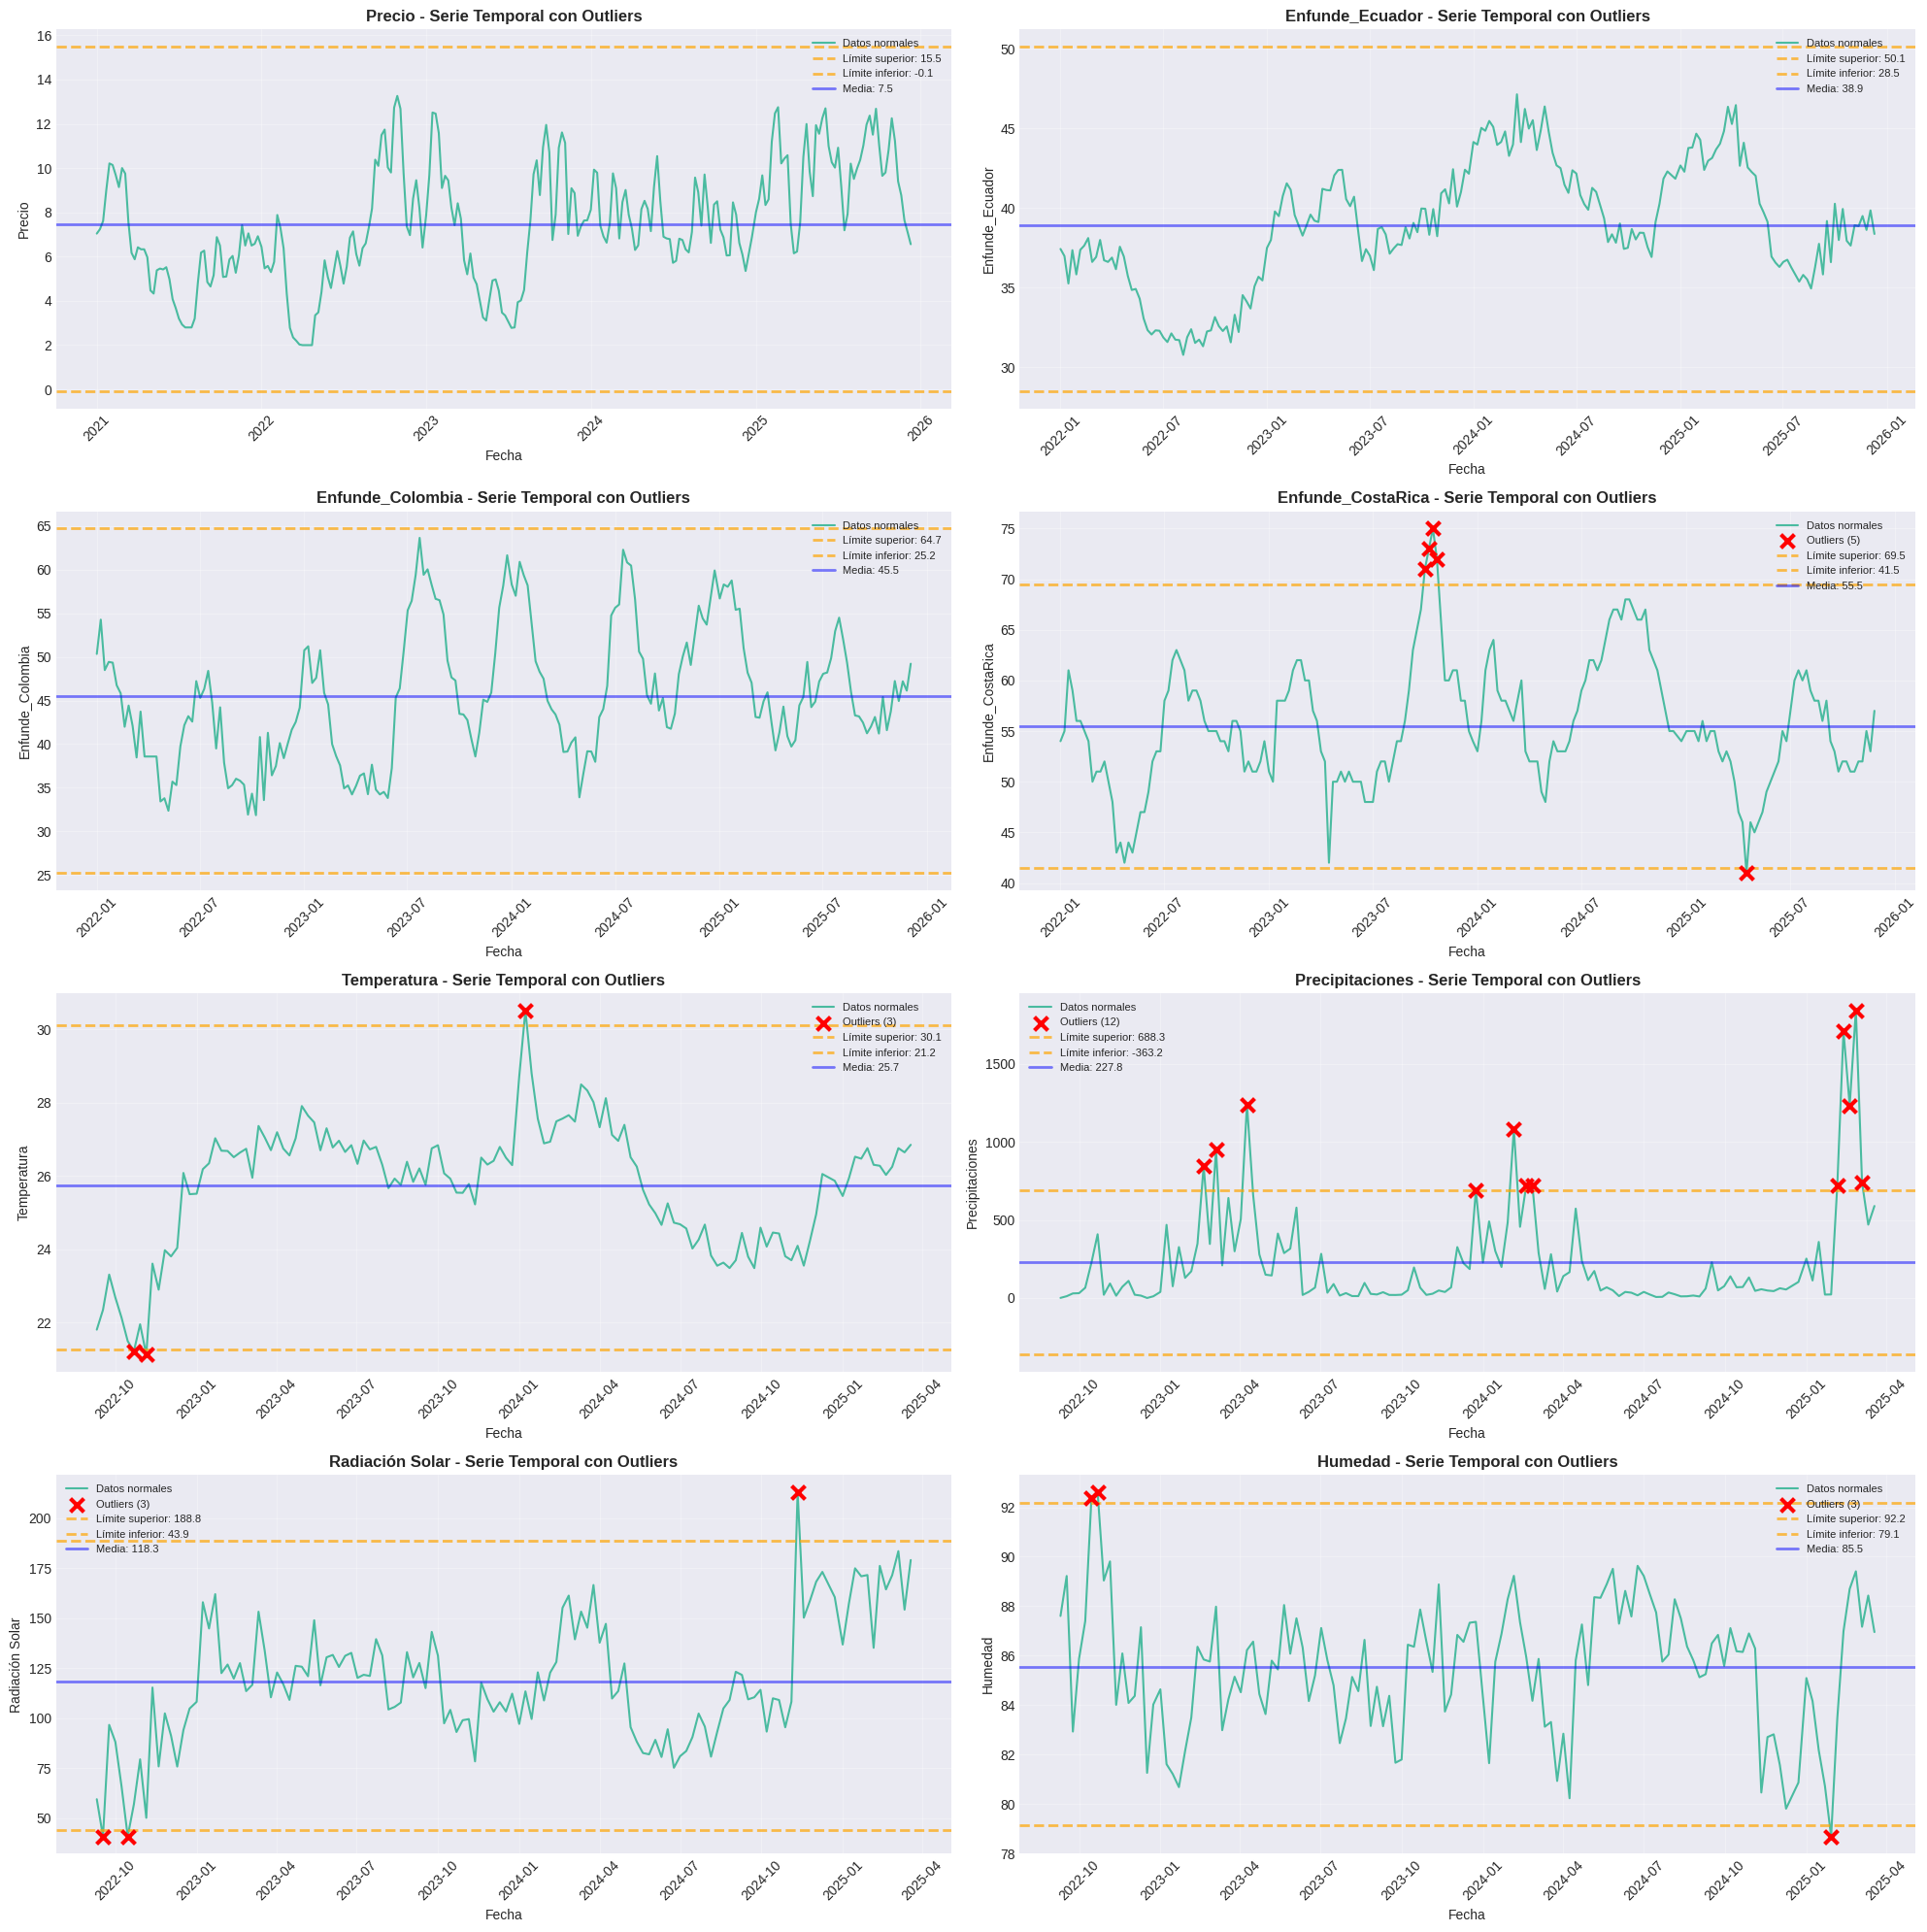


✓ Serie temporal con outliers resaltados generada


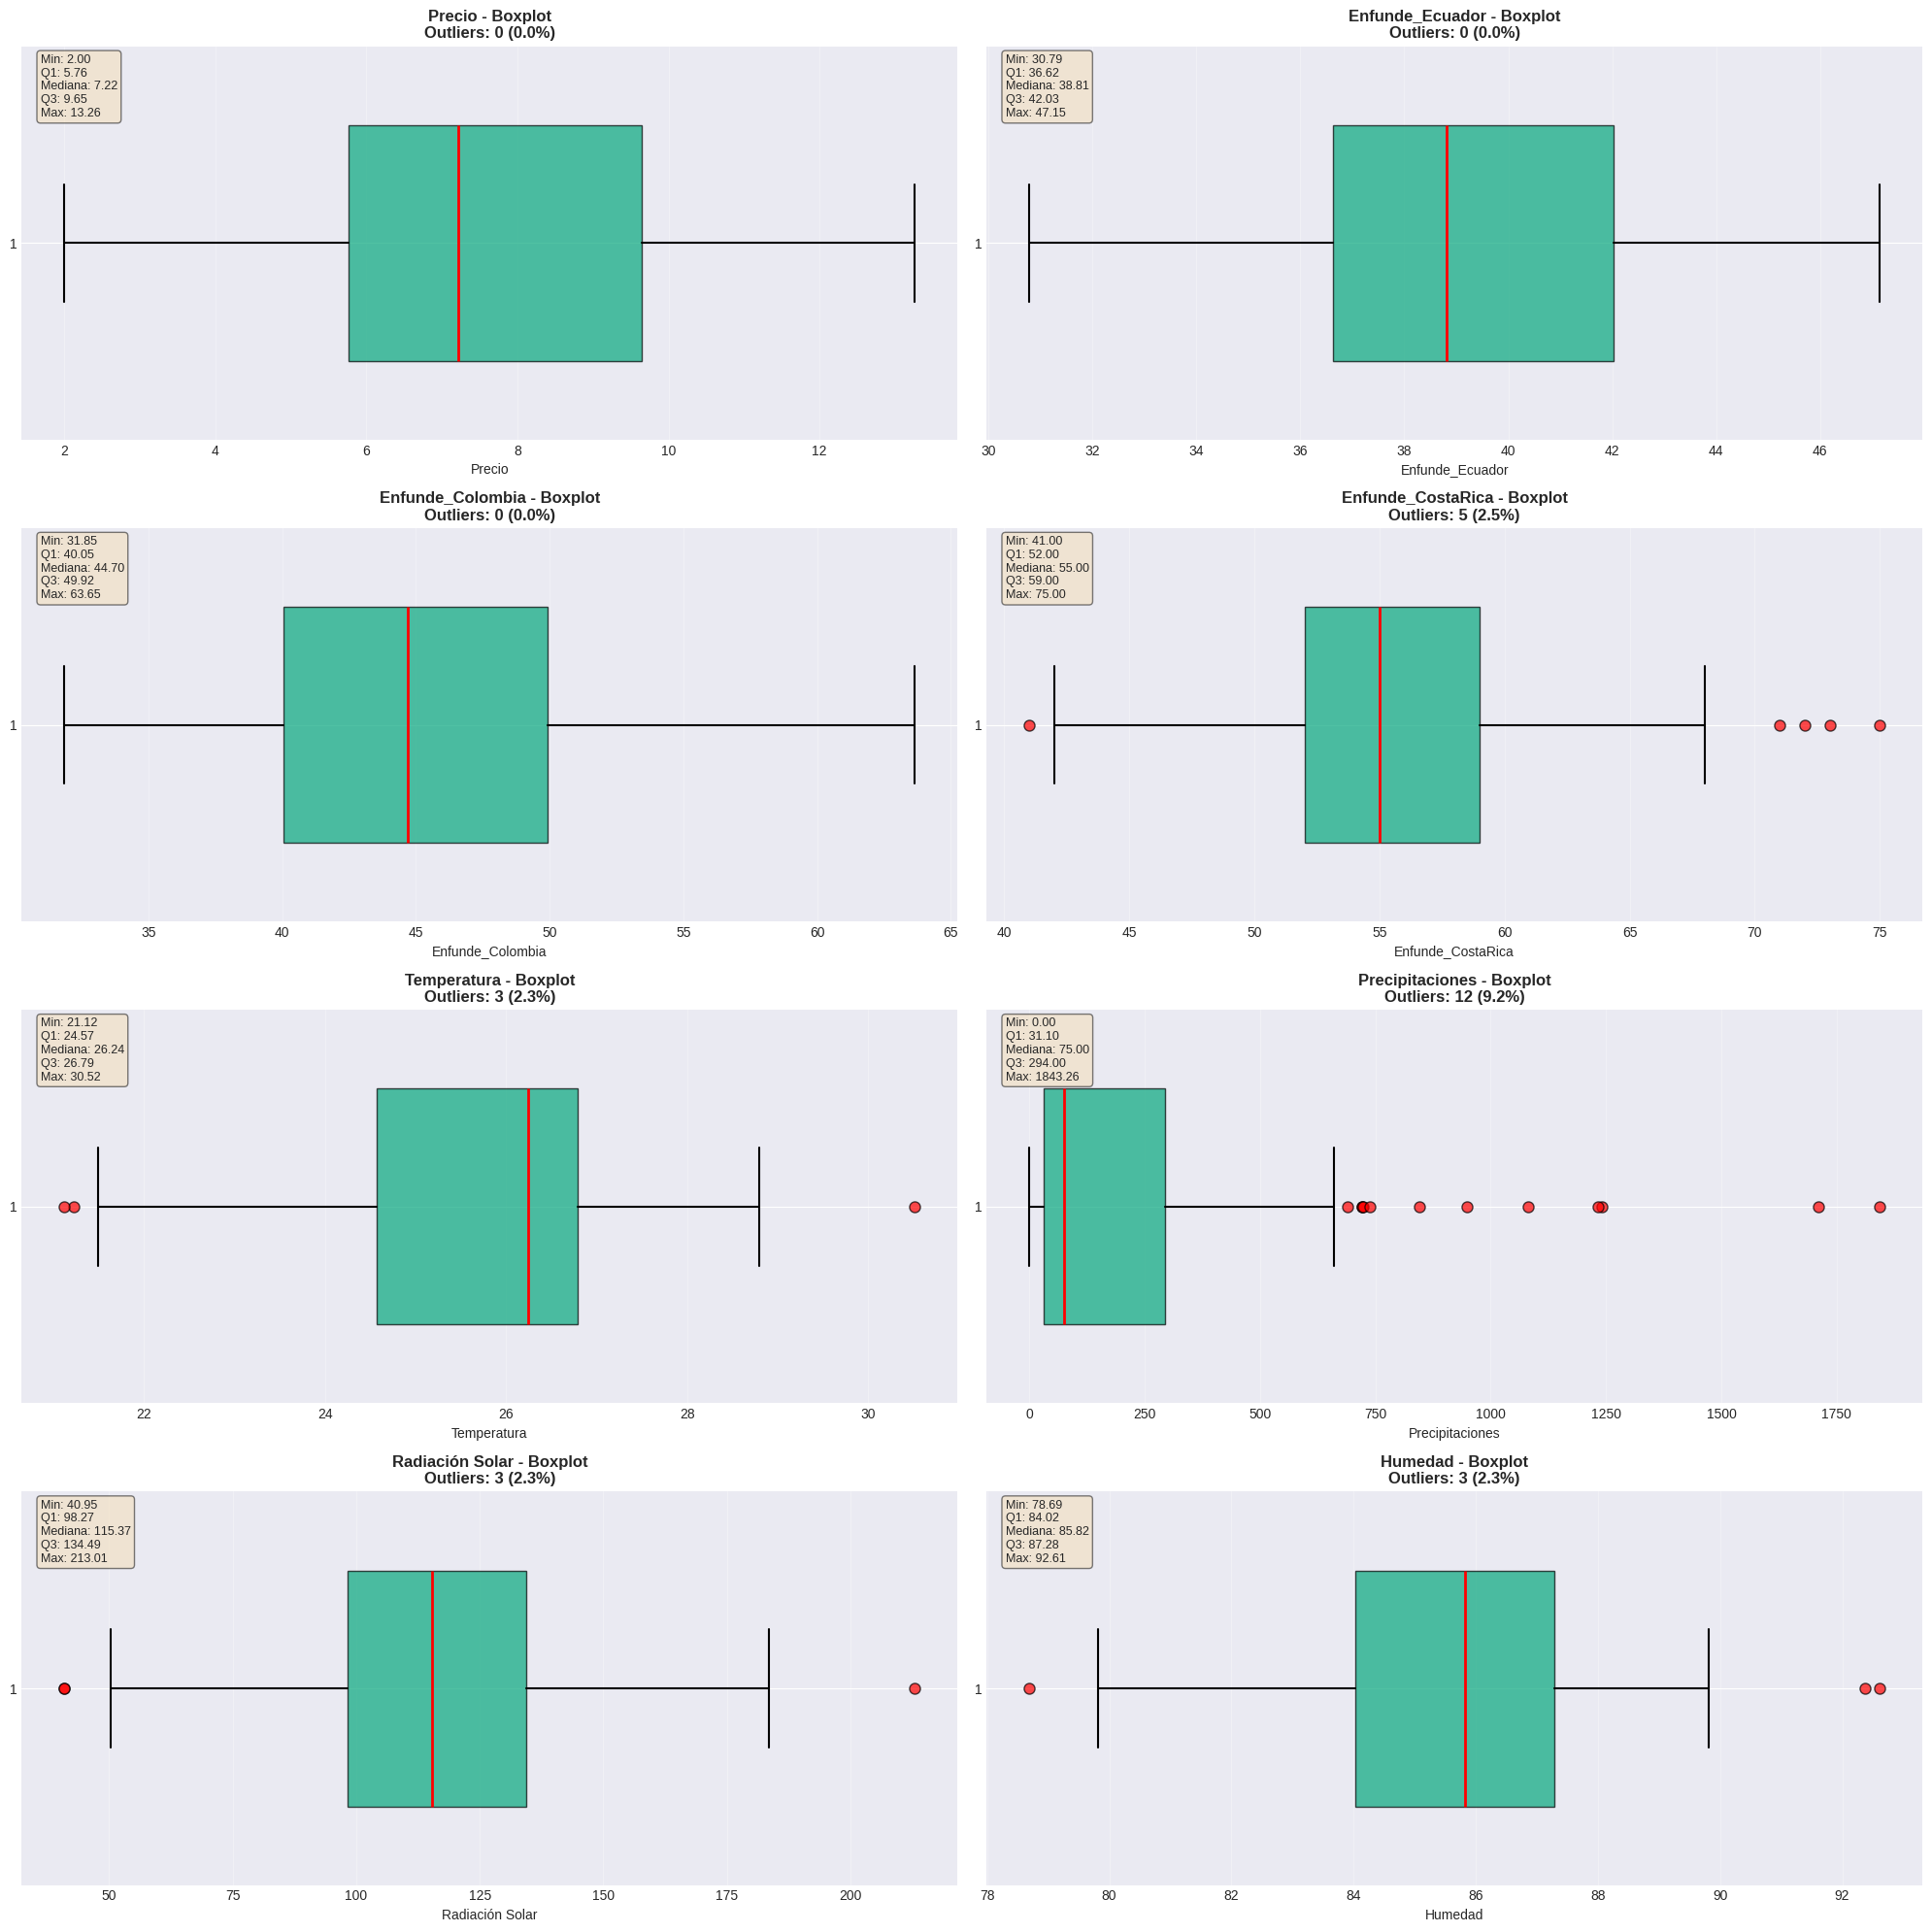

✓ Boxplots comparativos generados


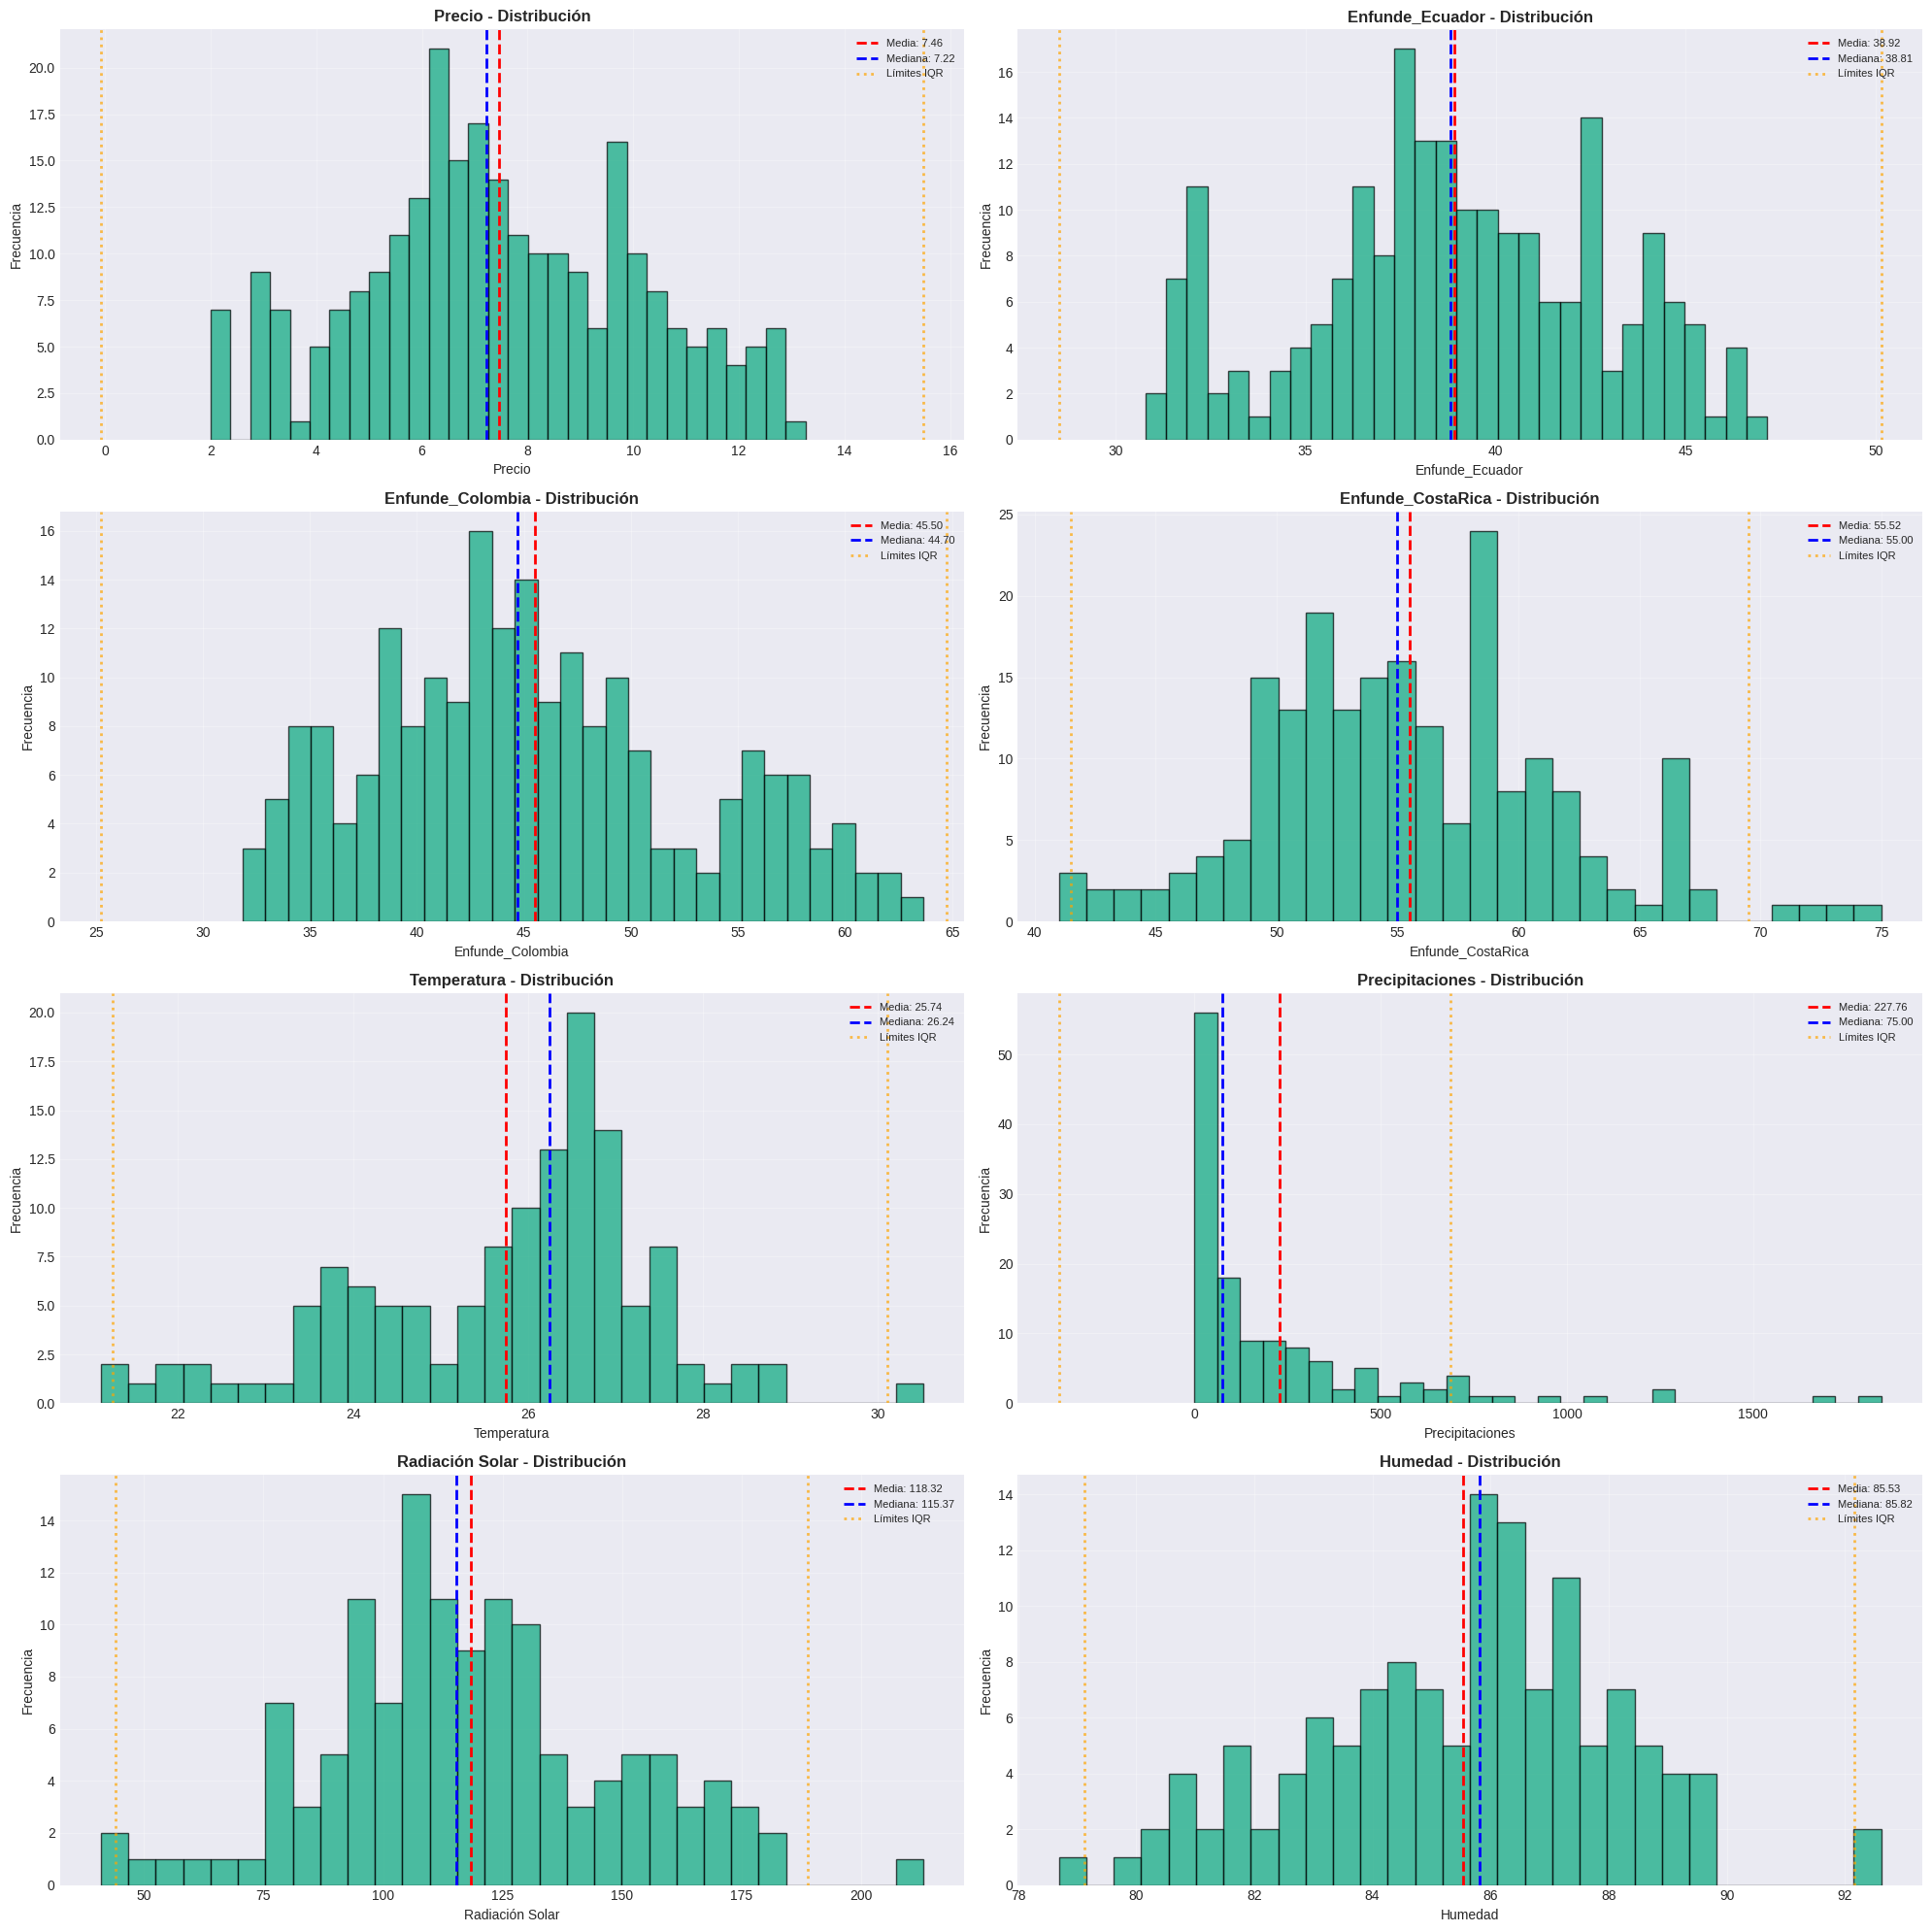

✓ Distribuciones con outliers generadas

ANÁLISIS DE COINCIDENCIA DE OUTLIERS

Coincidencias de outliers entre variables:
--------------------------------------------------------------------------------
Temperatura ↔ Humedad: 1 coincidencias
Radiación Solar ↔ Humedad: 1 coincidencias

TABLA RESUMEN - OUTLIERS POR VARIABLE


                   N° Outliers  % Outliers     Mínimo         Q1          Q3       Máximo  Límite Inf  Límite Sup
Precio                     0.0    0.000000   2.000000   5.760000    9.650000    13.260000   -0.075000   15.485000
Enfunde_Ecuador            0.0    0.000000  30.786850  36.624330   42.030000    47.146561   28.515824   50.138506
Enfunde_Colombia           0.0    0.000000  31.852730  40.045000   49.917500    63.650000   25.236250   64.726250
Enfunde_CostaRica          5.0    2.463054  41.000000  52.000000   59.000000    75.000000   41.500000   69.500000
Temperatura                3.0    2.290076  21.118359  24.572768   26.788016    30.515398   21.249897   

In [ ]:
# Análisis de Outliers para TODAS las Variables
# Lista de variables numéricas a analizar
variables_numericas = ['Precio', 'Enfunde_Ecuador', 'Enfunde_Colombia', 'Enfunde_CostaRica',
                        'Temperatura', 'Precipitaciones', 'Radiación Solar', 'Humedad']

# Filtrar solo las que existen en el dataframe
variables_disponibles = [var for var in variables_numericas if var in df_master.columns]

print("="*80)
print("ANÁLISIS DE OUTLIERS - TODAS LAS VARIABLES")
print("="*80)

# Función para detectar outliers usando IQR
def detectar_outliers_iqr(data, columna):
    """Detecta outliers usando el método IQR (Rango Intercuartílico)"""
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]
    return outliers, limite_inferior, limite_superior, Q1, Q3

# Análisis estadístico de outliers
print("\nRESUMEN DE OUTLIERS POR VARIABLE:")
print("-"*80)

resultados_outliers = {}

for var in variables_disponibles:
    if df_master[var].notna().sum() > 0:  # Solo si hay datos
        outliers, lim_inf, lim_sup, Q1, Q3 = detectar_outliers_iqr(df_master, var)
        n_outliers = len(outliers)
        pct_outliers = (n_outliers / df_master[var].notna().sum()) * 100

        resultados_outliers[var] = {
            'n_outliers': n_outliers,
            'pct_outliers': pct_outliers,
            'limite_inferior': lim_inf,
            'limite_superior': lim_sup,
            'Q1': Q1,
            'Q3': Q3,
            'min': df_master[var].min(),
            'max': df_master[var].max()
        }

        print(f"\n{var}:")
        print(f"  Total outliers: {n_outliers} ({pct_outliers:.1f}%)")
        print(f"  Rango normal: [{lim_inf:.2f}, {lim_sup:.2f}]")
        print(f"  Valores extremos: Min={df_master[var].min():.2f}, Max={df_master[var].max():.2f}")

# VISUALIZACIÓN 1: Serie temporal con outliers resaltados
print("\n" + "="*80)
print("VISUALIZACIONES GENERADAS")
print("="*80)

n_vars = len(variables_disponibles)
n_cols = 2
n_rows = (n_vars + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

for idx, var in enumerate(variables_disponibles):
    if df_master[var].notna().sum() > 0:
        # Datos válidos
        df_plot = df_master[['Fecha', var]].dropna()

        # Detectar outliers
        outliers, lim_inf, lim_sup, Q1, Q3 = detectar_outliers_iqr(df_plot, var)

        # Plot serie temporal
        axes[idx].plot(df_plot['Fecha'], df_plot[var], linewidth=1.5,
                      color='#06A77D', alpha=0.7, label='Datos normales')

        # Resaltar outliers
        if len(outliers) > 0:
            axes[idx].scatter(outliers['Fecha'], outliers[var],
                            color='red', s=100, zorder=5,
                            label=f'Outliers ({len(outliers)})', marker='x', linewidths=3)

        # Límites IQR
        axes[idx].axhline(lim_sup, color='orange', linestyle='--',
                         linewidth=2, alpha=0.7, label=f'Límite superior: {lim_sup:.1f}')
        axes[idx].axhline(lim_inf, color='orange', linestyle='--',
                         linewidth=2, alpha=0.7, label=f'Límite inferior: {lim_inf:.1f}')

        # Media
        media = df_plot[var].mean()
        axes[idx].axhline(media, color='blue', linestyle='-',
                         linewidth=2, alpha=0.5, label=f'Media: {media:.1f}')

        axes[idx].set_title(f'{var} - Serie Temporal con Outliers',
                          fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Fecha')
        axes[idx].set_ylabel(var)
        axes[idx].legend(loc='best', fontsize=8)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos
for idx in range(len(variables_disponibles), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✓ Serie temporal con outliers resaltados generada")

# VISUALIZACIÓN 2: Boxplots comparativos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

for idx, var in enumerate(variables_disponibles):
    if df_master[var].notna().sum() > 0:
        # Boxplot
        bp = axes[idx].boxplot(df_master[var].dropna(), vert=False,
                              widths=0.6, patch_artist=True,
                              boxprops=dict(facecolor='#06A77D', alpha=0.7),
                              medianprops=dict(color='red', linewidth=2),
                              whiskerprops=dict(color='black', linewidth=1.5),
                              capprops=dict(color='black', linewidth=1.5),
                              flierprops=dict(marker='o', markerfacecolor='red',
                                            markersize=8, alpha=0.7))

        # Estadísticas
        stats = resultados_outliers[var]
        axes[idx].set_title(f'{var} - Boxplot\nOutliers: {stats["n_outliers"]} ({stats["pct_outliers"]:.1f}%)',
                          fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(var)
        axes[idx].grid(True, alpha=0.3, axis='x')

        # Agregar texto con estadísticas
        texto_stats = f"Min: {stats['min']:.2f}\nQ1: {stats['Q1']:.2f}\nMediana: {df_master[var].median():.2f}\nQ3: {stats['Q3']:.2f}\nMax: {stats['max']:.2f}"
        axes[idx].text(0.02, 0.98, texto_stats, transform=axes[idx].transAxes,
                      fontsize=9, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Ocultar subplots vacíos
for idx in range(len(variables_disponibles), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("✓ Boxplots comparativos generados")

# VISUALIZACIÓN 3: Distribuciones con outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

for idx, var in enumerate(variables_disponibles):
    if df_master[var].notna().sum() > 0:
        # Histograma
        axes[idx].hist(df_master[var].dropna(), bins=30,
                      edgecolor='black', alpha=0.7, color='#06A77D')

        # Líneas de referencia
        media = df_master[var].mean()
        mediana = df_master[var].median()
        stats = resultados_outliers[var]

        axes[idx].axvline(media, color='red', linestyle='--',
                         linewidth=2, label=f'Media: {media:.2f}')
        axes[idx].axvline(mediana, color='blue', linestyle='--',
                         linewidth=2, label=f'Mediana: {mediana:.2f}')
        axes[idx].axvline(stats['limite_inferior'], color='orange',
                         linestyle=':', linewidth=2, label='Límites IQR', alpha=0.7)
        axes[idx].axvline(stats['limite_superior'], color='orange',
                         linestyle=':', linewidth=2, alpha=0.7)

        axes[idx].set_title(f'{var} - Distribución',
                          fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(var)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, alpha=0.3)

# Ocultar subplots vacíos
for idx in range(len(variables_disponibles), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("✓ Distribuciones con outliers generadas")

# VISUALIZACIÓN 4: Matriz de correlación de outliers
print("\n" + "="*80)
print("ANÁLISIS DE COINCIDENCIA DE OUTLIERS")
print("="*80)

# Crear DataFrame de outliers (1 = outlier, 0 = normal)
df_outliers = pd.DataFrame(index=df_master.index)

for var in variables_disponibles:
    if df_master[var].notna().sum() > 0:
        outliers, lim_inf, lim_sup, _, _ = detectar_outliers_iqr(df_master, var)
        df_outliers[f'{var}_outlier'] = 0
        df_outliers.loc[outliers.index, f'{var}_outlier'] = 1

# Contar coincidencias
if len(df_outliers.columns) > 1:
    print("\nCoincidencias de outliers entre variables:")
    print("-"*80)

    for i, var1 in enumerate(df_outliers.columns):
        for var2 in df_outliers.columns[i+1:]:
            coincidencias = (df_outliers[var1] & df_outliers[var2]).sum()
            if coincidencias > 0:
                print(f"{var1.replace('_outlier', '')} ↔ {var2.replace('_outlier', '')}: {coincidencias} coincidencias")

# TABLA RESUMEN FINAL
print("\n" + "="*80)
print("TABLA RESUMEN - OUTLIERS POR VARIABLE")
print("="*80)

df_resumen = pd.DataFrame(resultados_outliers).T
df_resumen = df_resumen[['n_outliers', 'pct_outliers', 'min', 'Q1', 'Q3', 'max',
                         'limite_inferior', 'limite_superior']]
df_resumen.columns = ['N° Outliers', '% Outliers', 'Mínimo', 'Q1', 'Q3', 'Máximo',
                      'Límite Inf', 'Límite Sup']

print("\n")
print(df_resumen.to_string())

# Identificar variables con más outliers
print("\n" + "="*80)
print("VARIABLES CON MÁS OUTLIERS")
print("="*80)

top_outliers = df_resumen.sort_values('% Outliers', ascending=False)
for idx, (var, row) in enumerate(top_outliers.iterrows(), 1):
    print(f"{idx}. {var}: {int(row['N° Outliers'])} outliers ({row['% Outliers']:.1f}%)")

print("\n" + "="*80)
print("RECOMENDACIONES")
print("="*80)

for var, stats in resultados_outliers.items():
    if stats['pct_outliers'] > 5:
        print(f"\n⚠️  {var}: {stats['pct_outliers']:.1f}% outliers (>{5}%)")
        print(f"   → Revisar datos atípicos o considerar transformación")
        print(f"   → Rango normal: [{stats['limite_inferior']:.2f}, {stats['limite_superior']:.2f}]")
    elif stats['pct_outliers'] > 0:
        print(f"\n✓ {var}: {stats['pct_outliers']:.1f}% outliers (<5% - aceptable)")

print("\n" + "="*80)

### 4.1 Descomposición de Serie Temporal del Precio

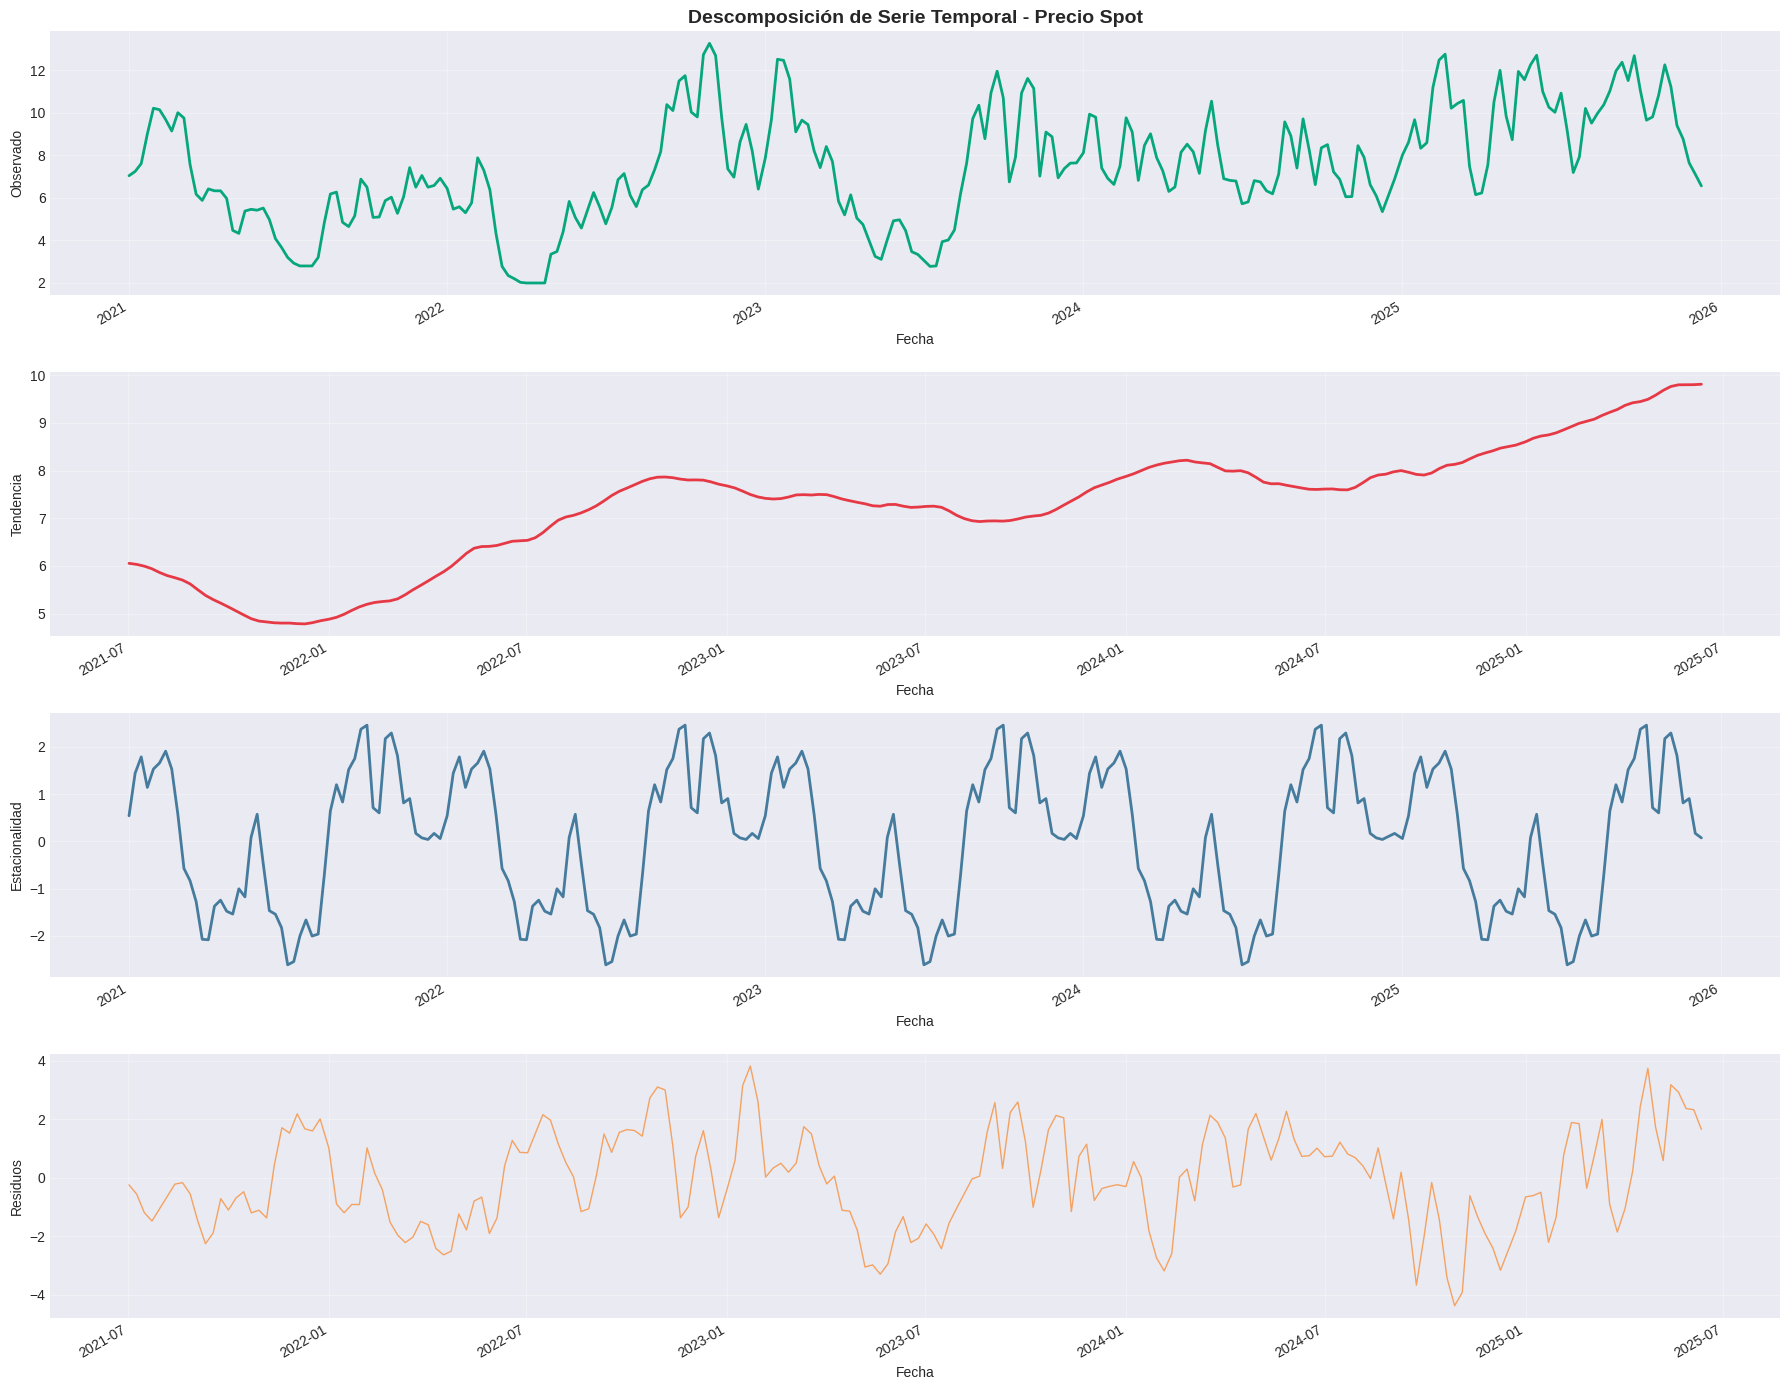

In [ ]:
# Descomposición del precio
df_precio_ts = df_master.set_index('Fecha')['Precio'].dropna()
decomposition = seasonal_decompose(df_precio_ts, model='additive', period=52)

fig, axes = plt.subplots(4, 1, figsize=(18, 14))

decomposition.observed.plot(ax=axes[0], color='#06A77D', linewidth=2)
axes[0].set_ylabel('Observado')
axes[0].set_title('Descomposición de Serie Temporal - Precio Spot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='#E63946', linewidth=2)
axes[1].set_ylabel('Tendencia')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='#457B9D', linewidth=2)
axes[2].set_ylabel('Estacionalidad')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='#F4A261', linewidth=1)
axes[3].set_ylabel('Residuos')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Descomposición de Serie Temporal del Precio (Estacionalidad Semanal)

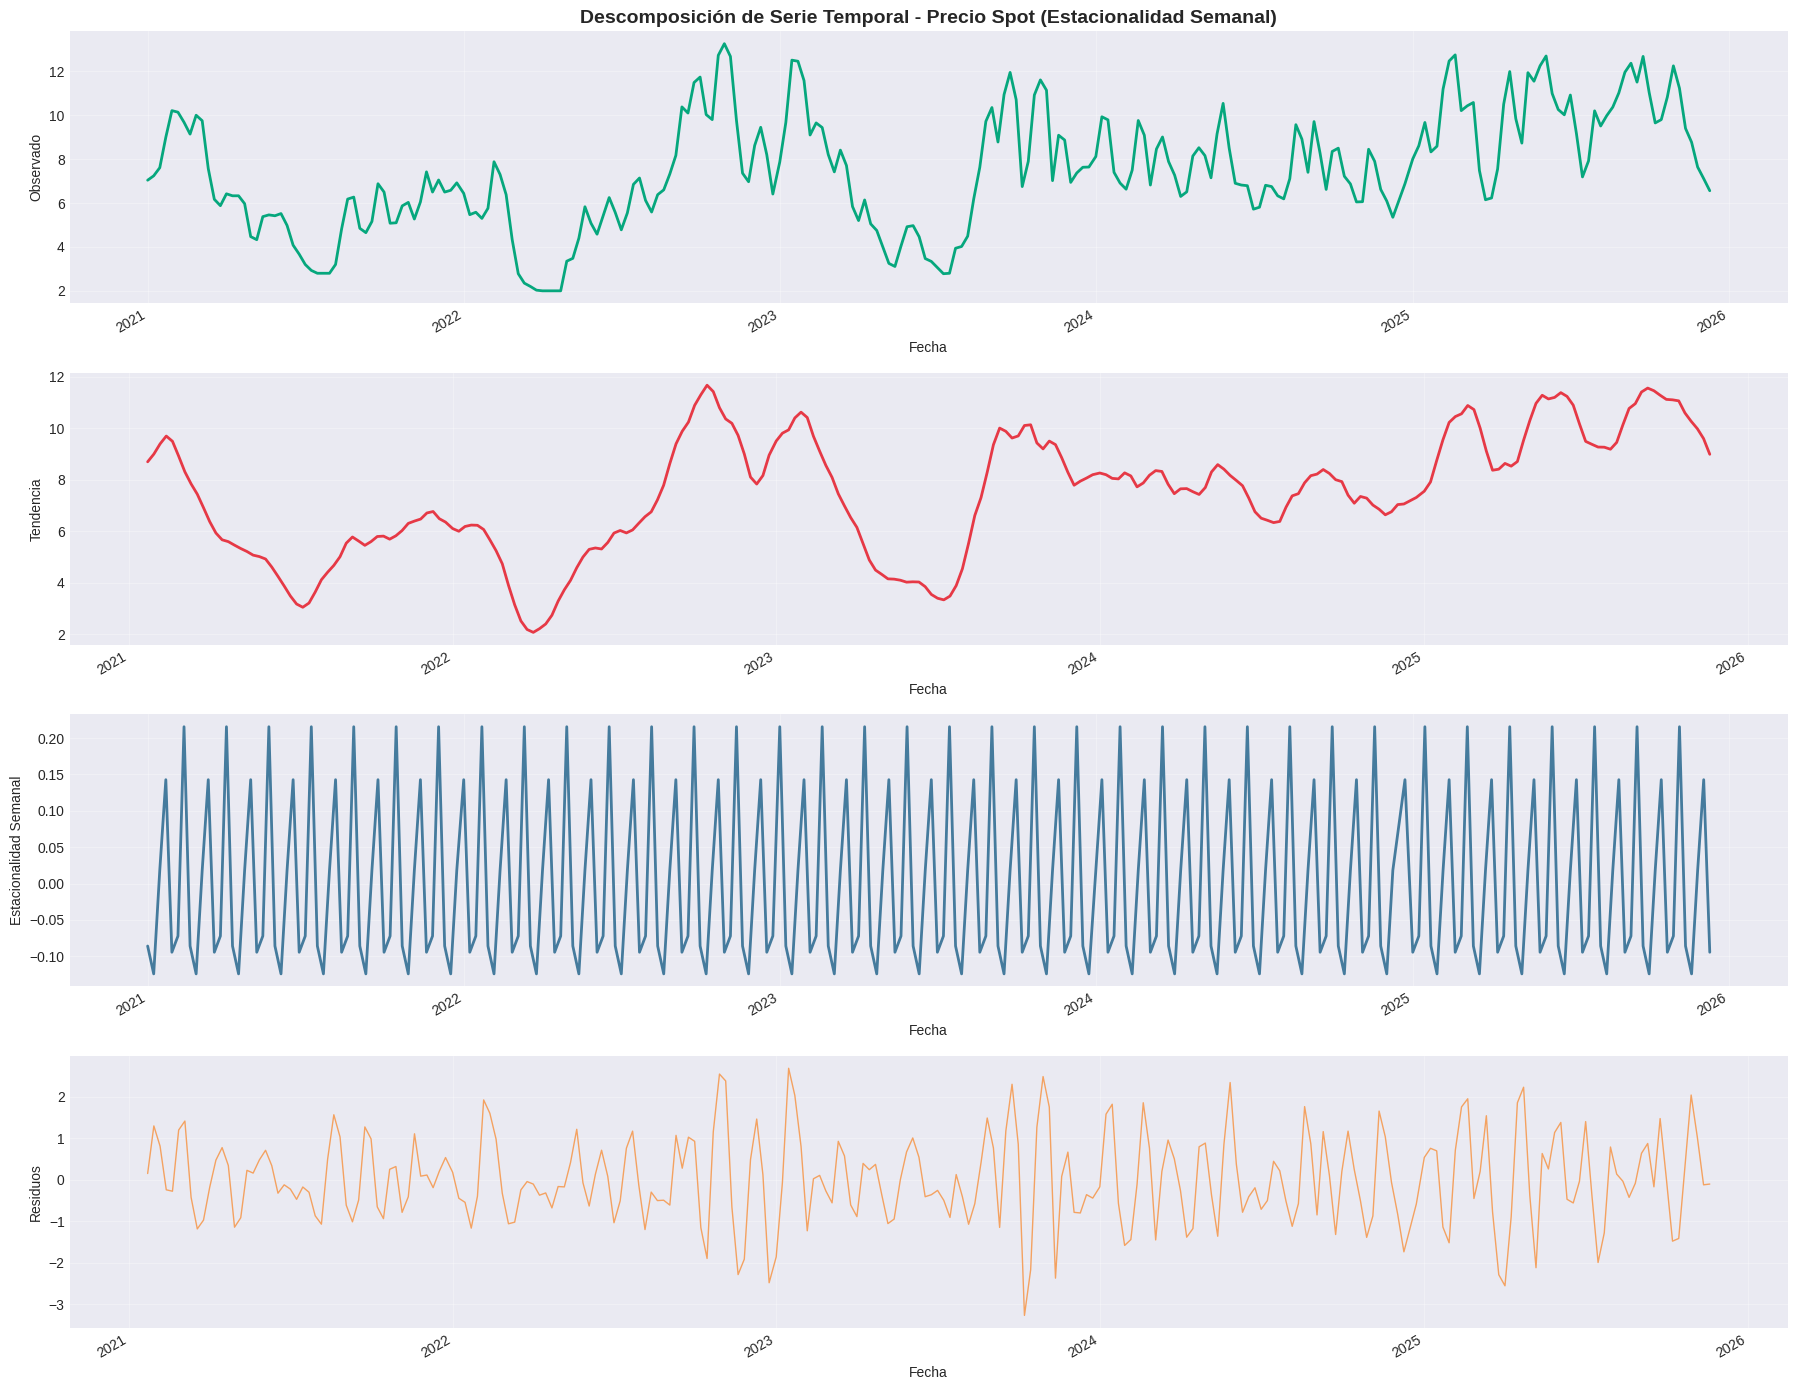

In [ ]:
# Descomposición del precio con estacionalidad semanal (period=7)
df_precio_ts = df_master.set_index('Fecha')['Precio'].dropna()
decomposition_weekly = seasonal_decompose(df_precio_ts, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(18, 14))

decomposition_weekly.observed.plot(ax=axes[0], color='#06A77D', linewidth=2)
axes[0].set_ylabel('Observado')
axes[0].set_title('Descomposición de Serie Temporal - Precio Spot (Estacionalidad Semanal)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomposition_weekly.trend.plot(ax=axes[1], color='#E63946', linewidth=2)
axes[1].set_ylabel('Tendencia')
axes[1].grid(True, alpha=0.3)

decomposition_weekly.seasonal.plot(ax=axes[2], color='#457B9D', linewidth=2)
axes[2].set_ylabel('Estacionalidad Semanal')
axes[2].grid(True, alpha=0.3)

decomposition_weekly.resid.plot(ax=axes[3], color='#F4A261', linewidth=1)
axes[3].set_ylabel('Residuos')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 🔗 5. Análisis de Correlaciones

### 5.1 Correlación Contemporánea (mismo período)

CORRELACIONES CON PRECIO SPOT
Precio               1.000000
Fecha                0.479331
Enfunde_CostaRica    0.253769
Enfunde_ElOro        0.176581
Precipitaciones      0.139294
Enfunde_Guayas       0.106459
Enfunde_Ecuador      0.083383
Humedad              0.028958
Enfunde_Colombia    -0.000502
Radiación Solar     -0.047587
Enfunde_LosRios     -0.099180
Temperatura         -0.252798
Name: Precio, dtype: float64



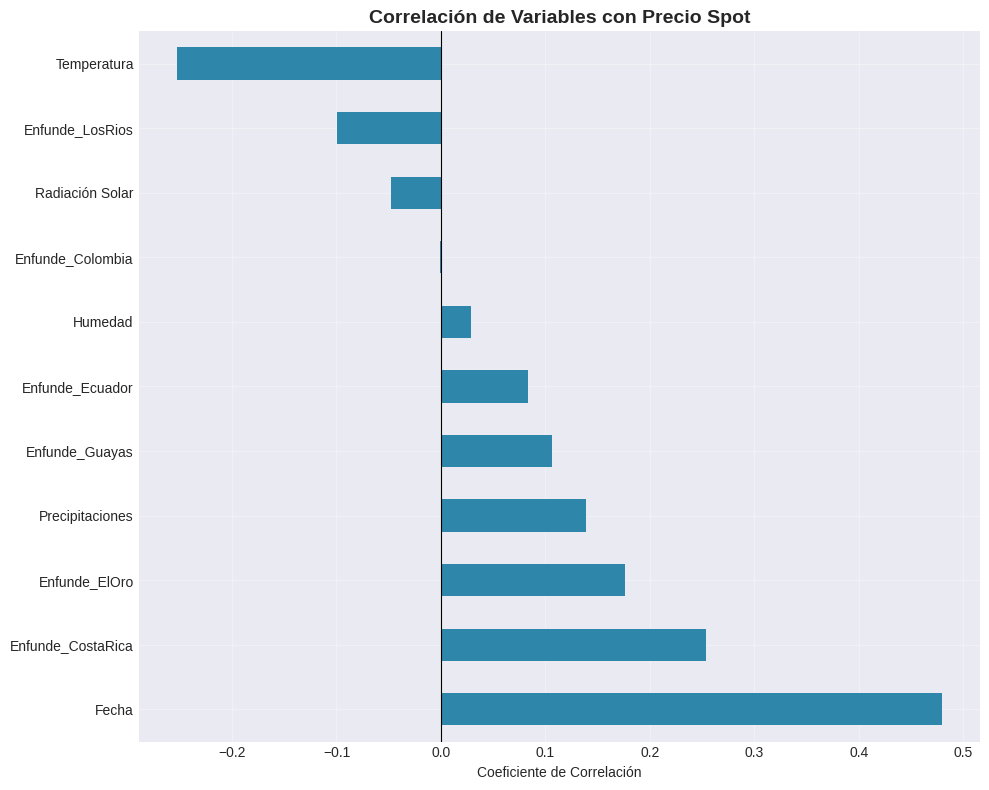

In [ ]:
# Calcular correlaciones con Precio
correlaciones = df_master.corr()['Precio'].sort_values(ascending=False)

print("="*80)
print("CORRELACIONES CON PRECIO SPOT")
print("="*80)
print(correlaciones)
print("\n" + "="*80)

# Visualización
fig, ax = plt.subplots(figsize=(10, 8))
correlaciones[correlaciones.index != 'Precio'].plot(kind='barh', ax=ax, color='#2E86AB')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Correlación de Variables con Precio Spot', fontsize=14, fontweight='bold')
ax.set_xlabel('Coeficiente de Correlación')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2 Matriz de Correlación General

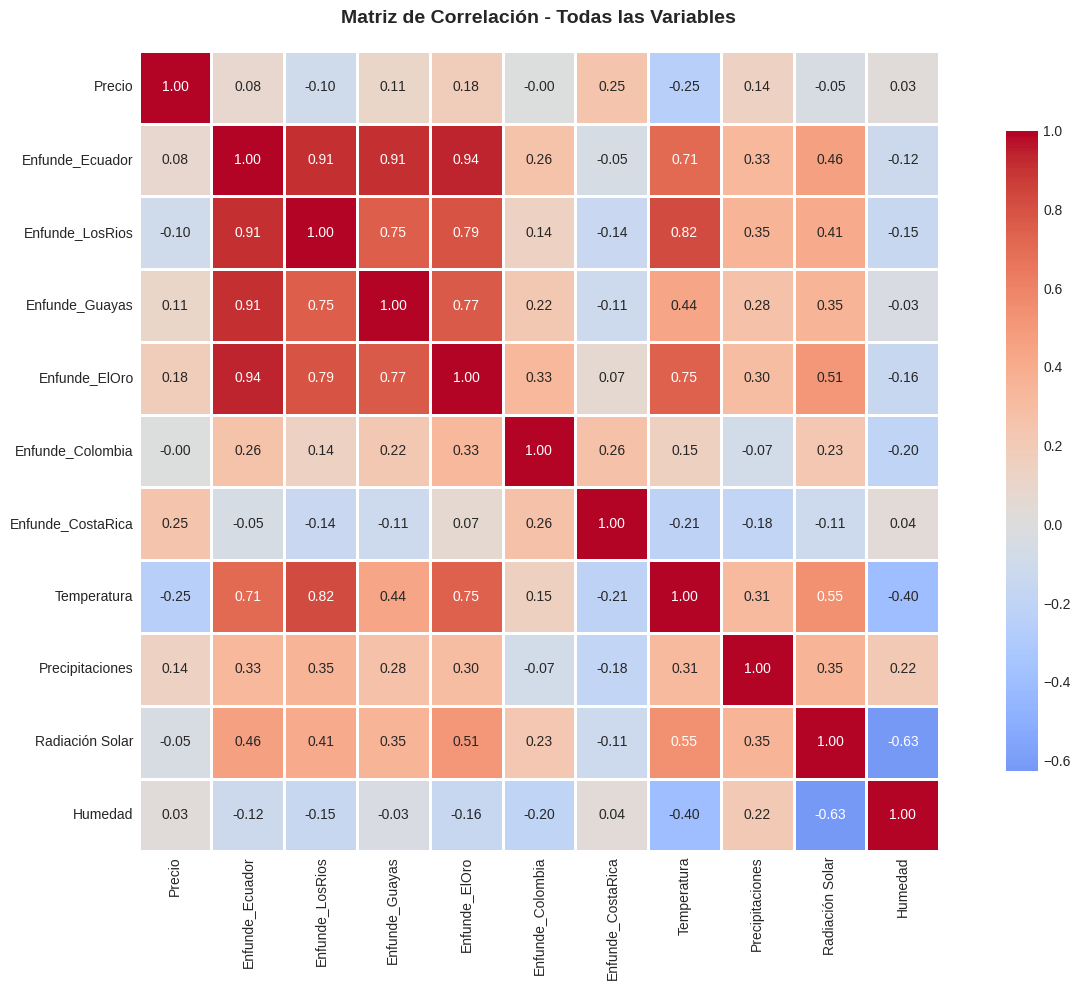

In [ ]:
# Matriz de correlación completa
plt.figure(figsize=(14, 10))
correlation_matrix = df_master.drop('Fecha', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Todas las Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 5.3 Scatter Plots - Relaciones Bivariadas

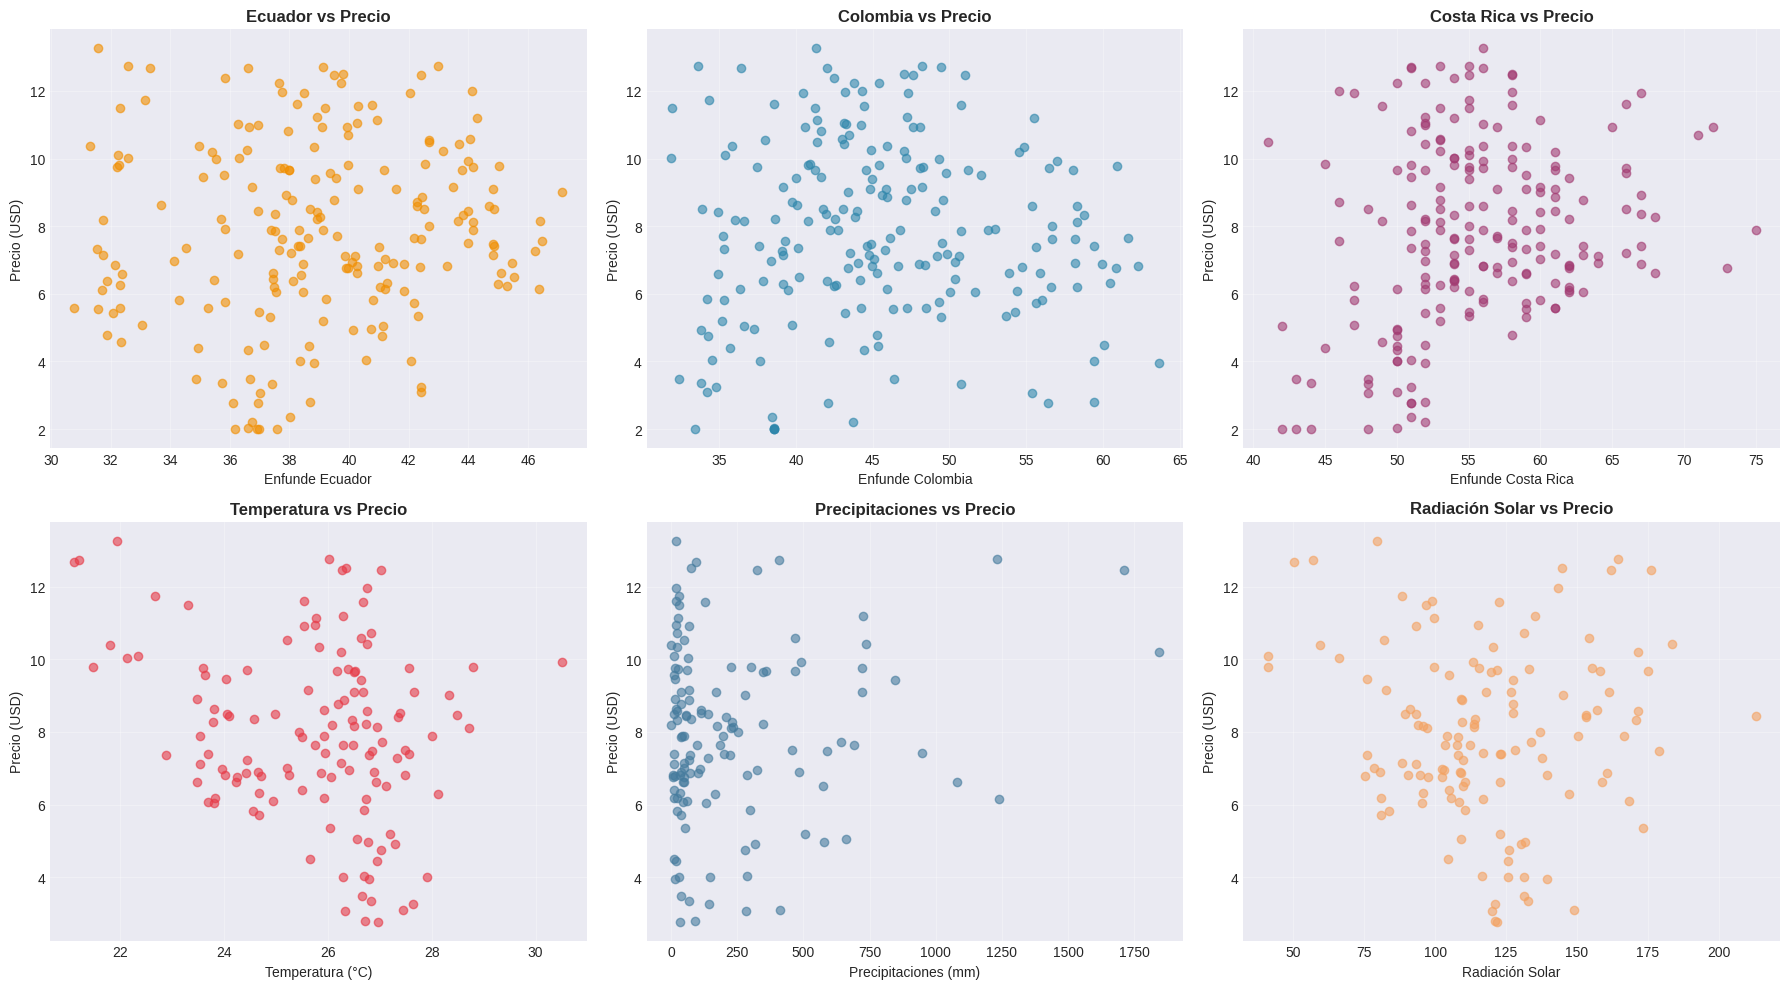

In [ ]:
# Gráficos de dispersión
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Ecuador
axes[0, 0].scatter(df_master['Enfunde_Ecuador'], df_master['Precio'], alpha=0.6, color='#F18F01')
axes[0, 0].set_xlabel('Enfunde Ecuador')
axes[0, 0].set_ylabel('Precio (USD)')
axes[0, 0].set_title('Ecuador vs Precio', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Colombia
axes[0, 1].scatter(df_master['Enfunde_Colombia'], df_master['Precio'], alpha=0.6, color='#2E86AB')
axes[0, 1].set_xlabel('Enfunde Colombia')
axes[0, 1].set_ylabel('Precio (USD)')
axes[0, 1].set_title('Colombia vs Precio', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Costa Rica
axes[0, 2].scatter(df_master['Enfunde_CostaRica'], df_master['Precio'], alpha=0.6, color='#A23B72')
axes[0, 2].set_xlabel('Enfunde Costa Rica')
axes[0, 2].set_ylabel('Precio (USD)')
axes[0, 2].set_title('Costa Rica vs Precio', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Variables climáticas
axes[1, 0].scatter(df_master['Temperatura'], df_master['Precio'], alpha=0.6, color='#E63946')
axes[1, 0].set_xlabel('Temperatura (°C)')
axes[1, 0].set_ylabel('Precio (USD)')
axes[1, 0].set_title('Temperatura vs Precio', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df_master['Precipitaciones'], df_master['Precio'], alpha=0.6, color='#457B9D')
axes[1, 1].set_xlabel('Precipitaciones (mm)')
axes[1, 1].set_ylabel('Precio (USD)')
axes[1, 1].set_title('Precipitaciones vs Precio', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].scatter(df_master['Radiación Solar'], df_master['Precio'], alpha=0.6, color='#F4A261')
axes[1, 2].set_xlabel('Radiación Solar')
axes[1, 2].set_ylabel('Precio (USD)')
axes[1, 2].set_title('Radiación Solar vs Precio', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4 Análisis de Correlación Cruzada con Lags

**¿El enfunde de hace N semanas predice el precio actual?**

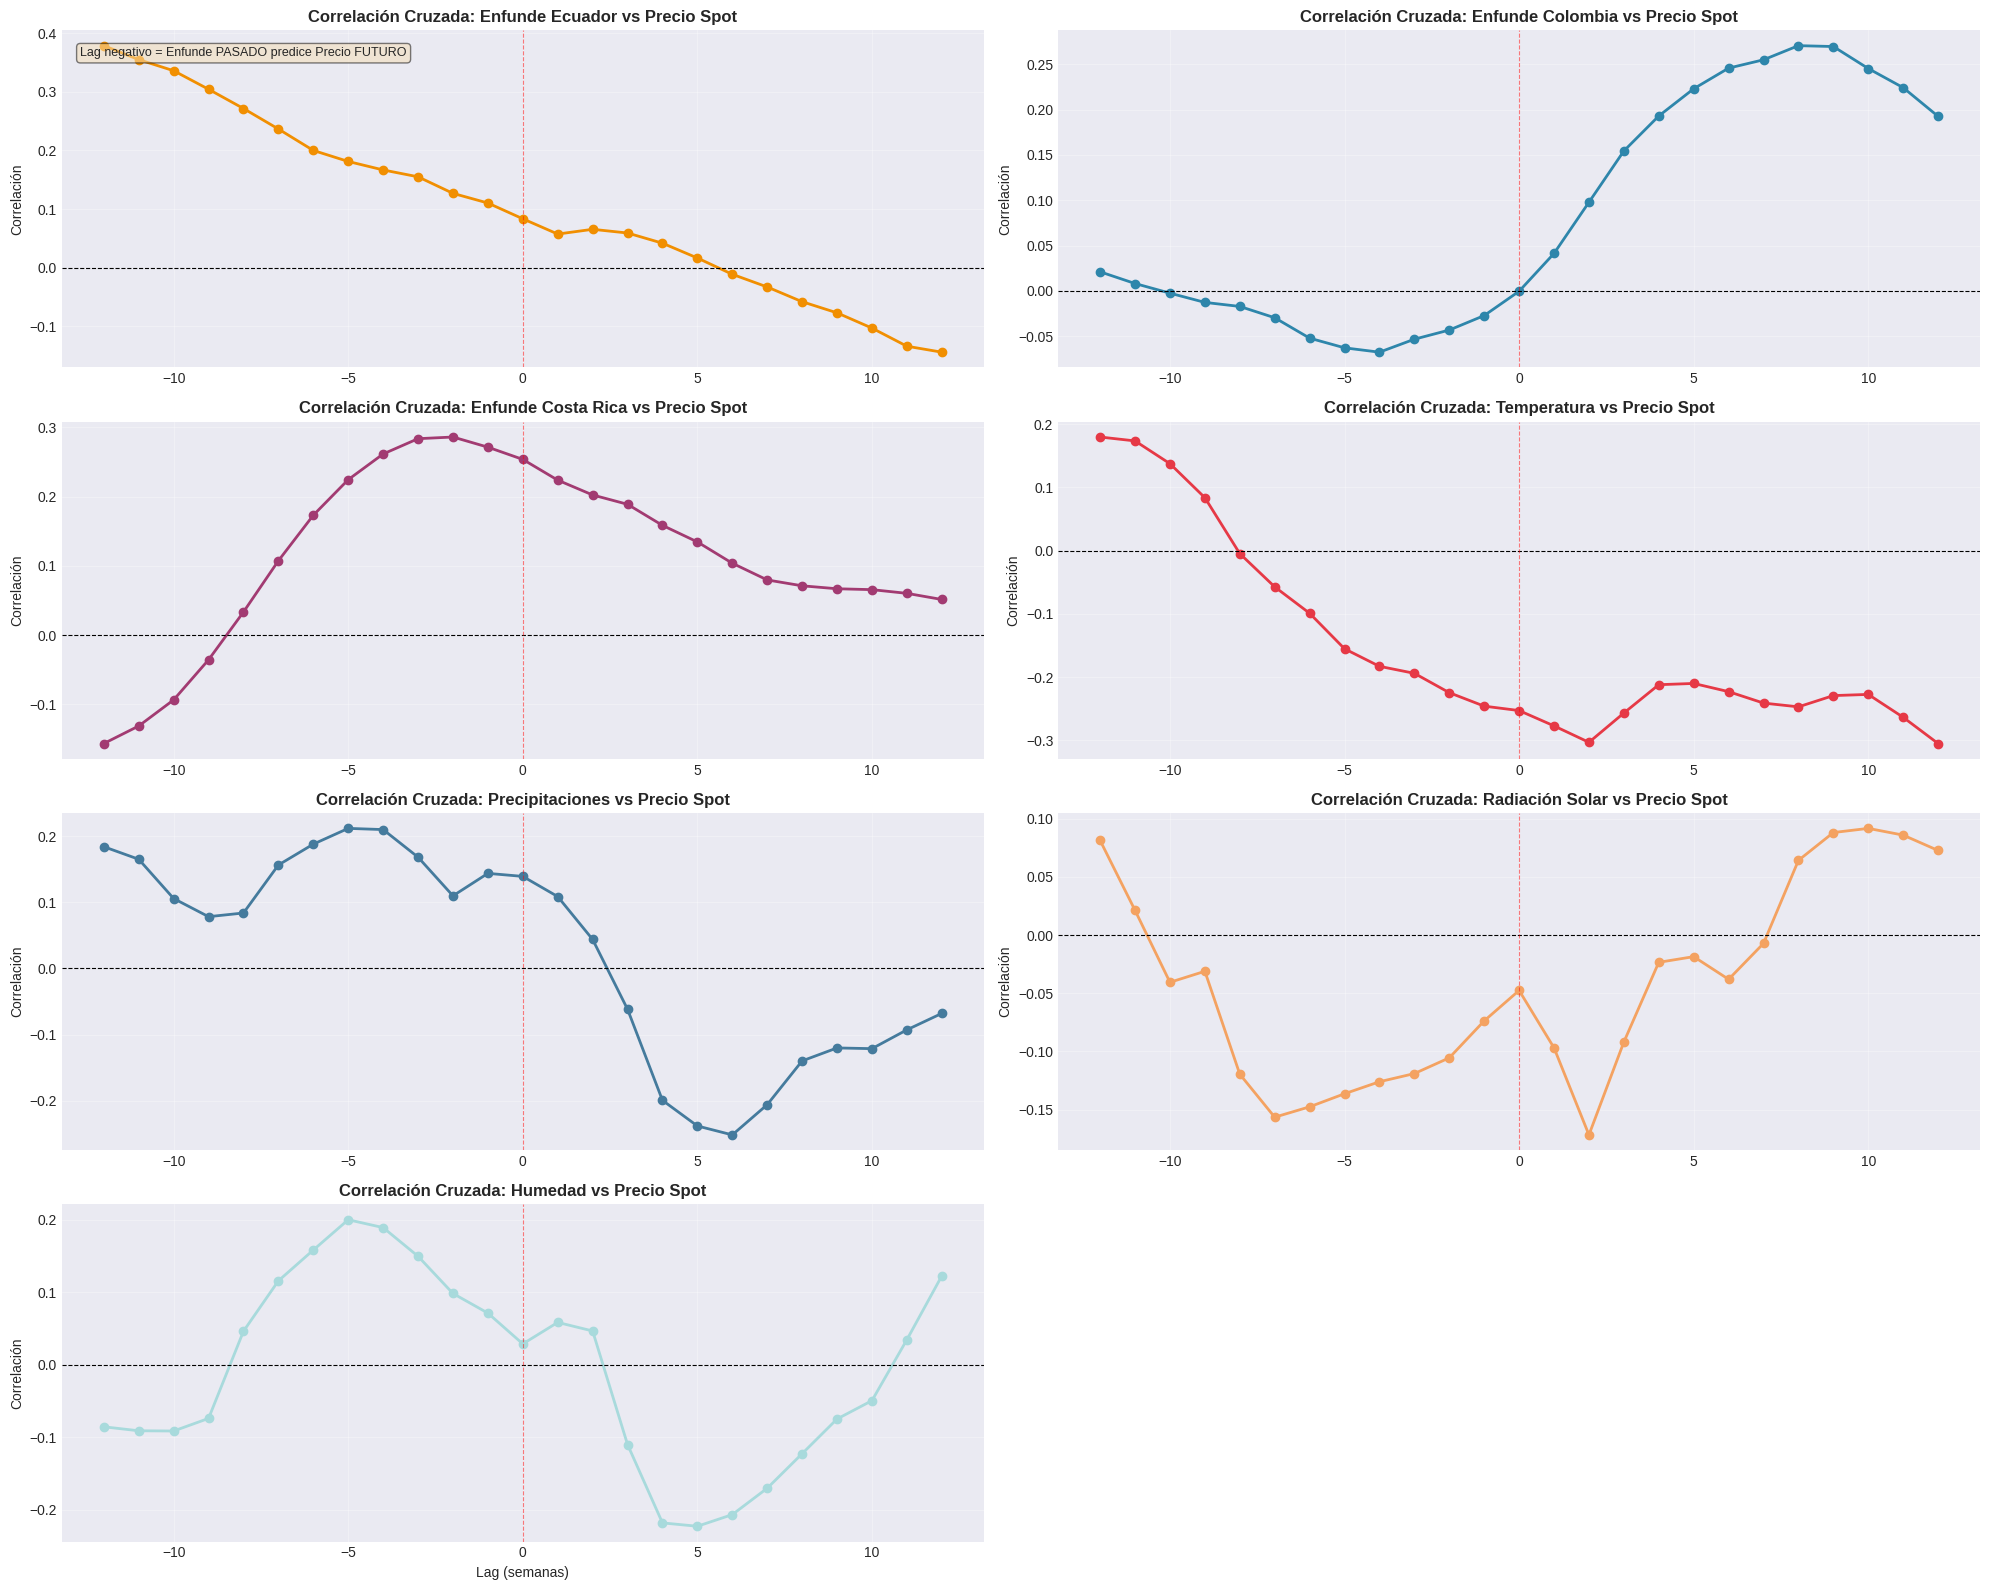


🔍 LAGS ÓPTIMOS (Mayor correlación absoluta):
Ecuador: Lag -12 semanas (corr: 0.378)
Colombia: Lag 8 semanas (corr: 0.271)
Costa Rica: Lag -2 semanas (corr: 0.286)
Temperatura: Lag 12 semanas (corr: -0.305)
Precipitaciones: Lag 6 semanas (corr: -0.252)
Radiación Solar: Lag 2 semanas (corr: -0.172)
Humedad: Lag 5 semanas (corr: -0.223)


In [ ]:
# Función para calcular correlación con lags
def calcular_lag_correlations(df, target_col, feature_col, max_lag=12):
    """
    Calcula correlación entre feature_col(t-lag) y target_col(t)
    Lag positivo: feature ADELANTADO predice target
    Lag negativo: feature RETRASADO predice target
    """
    correlations = []
    lags = []

    for lag in range(-max_lag, max_lag + 1):
        # Crear una copia para evitar SettingWithCopyWarning
        temp_df = df[[target_col, feature_col]].copy()
        temp_df[f'{feature_col}_lag'] = temp_df[feature_col].shift(lag)

        # Calcular correlación y manejar NaNs
        corr = temp_df[target_col].corr(temp_df[f'{feature_col}_lag'])
        correlations.append(corr)
        lags.append(lag)

    return lags, correlations

# Calcular lags para enfunde Ecuador
lags_ec, corr_ec = calcular_lag_correlations(df_master, 'Precio', 'Enfunde_Ecuador', max_lag=12)
lags_col, corr_col = calcular_lag_correlations(df_master, 'Precio', 'Enfunde_Colombia', max_lag=12)
lags_cr, corr_cr = calcular_lag_correlations(df_master, 'Precio', 'Enfunde_CostaRica', max_lag=12)

# Calcular lags para variables climáticas
lags_temp, corr_temp = calcular_lag_correlations(df_master, 'Precio', 'Temperatura', max_lag=12)
lags_prec, corr_prec = calcular_lag_correlations(df_master, 'Precio', 'Precipitaciones', max_lag=12)
lags_rad, corr_rad = calcular_lag_correlations(df_master, 'Precio', 'Radiación Solar', max_lag=12)
lags_hum, corr_hum = calcular_lag_correlations(df_master, 'Precio', 'Humedad', max_lag=12)

# Visualización
fig, axes = plt.subplots(4, 2, figsize=(20, 16)) # 4 filas, 2 columnas para 7 variables
axes = axes.flatten() # Aplanar para facilitar la iteración

# Enfunde Ecuador
axes[0].plot(lags_ec, corr_ec, marker='o', linewidth=2, color='#F18F01')
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[0].set_title('Correlación Cruzada: Enfunde Ecuador vs Precio Spot', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Correlación')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, 'Lag negativo = Enfunde PASADO predice Precio FUTURO',
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Enfunde Colombia
axes[1].plot(lags_col, corr_col, marker='o', linewidth=2, color='#2E86AB')
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[1].set_title('Correlación Cruzada: Enfunde Colombia vs Precio Spot', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Correlación')
axes[1].grid(True, alpha=0.3)

# Enfunde Costa Rica
axes[2].plot(lags_cr, corr_cr, marker='o', linewidth=2, color='#A23B72')
axes[2].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[2].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[2].set_title('Correlación Cruzada: Enfunde Costa Rica vs Precio Spot', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Correlación')
axes[2].grid(True, alpha=0.3)

# Temperatura
axes[3].plot(lags_temp, corr_temp, marker='o', linewidth=2, color='#E63946')
axes[3].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[3].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[3].set_title('Correlación Cruzada: Temperatura vs Precio Spot', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Correlación')
axes[3].grid(True, alpha=0.3)

# Precipitaciones
axes[4].plot(lags_prec, corr_prec, marker='o', linewidth=2, color='#457B9D')
axes[4].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[4].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[4].set_title('Correlación Cruzada: Precipitaciones vs Precio Spot', fontsize=12, fontweight='bold')
axes[4].set_ylabel('Correlación')
axes[4].grid(True, alpha=0.3)

# Radiación Solar
axes[5].plot(lags_rad, corr_rad, marker='o', linewidth=2, color='#F4A261')
axes[5].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[5].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[5].set_title('Correlación Cruzada: Radiación Solar vs Precio Spot', fontsize=12, fontweight='bold')
axes[5].set_ylabel('Correlación')
axes[5].grid(True, alpha=0.3)

# Humedad
axes[6].plot(lags_hum, corr_hum, marker='o', linewidth=2, color='#A8DADC')
axes[6].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[6].axvline(0, color='red', linewidth=0.8, linestyle='--', alpha=0.5)
axes[6].set_title('Correlación Cruzada: Humedad vs Precio Spot', fontsize=12, fontweight='bold')
axes[6].set_xlabel('Lag (semanas)')
axes[6].set_ylabel('Correlación')
axes[6].grid(True, alpha=0.3)

# Ocultar el último subplot si no se usa
if len(axes) > 7:
    axes[7].set_visible(False)

plt.tight_layout()
plt.show()

# Encontrar lags óptimos
print("\n🔍 LAGS ÓPTIMOS (Mayor correlación absoluta):")
print(f"Ecuador: Lag {lags_ec[np.argmax(np.abs(corr_ec))]} semanas (corr: {max(corr_ec, key=abs):.3f})")
print(f"Colombia: Lag {lags_col[np.argmax(np.abs(corr_col))]} semanas (corr: {max(corr_col, key=abs):.3f})")
print(f"Costa Rica: Lag {lags_cr[np.argmax(np.abs(corr_cr))]} semanas (corr: {max(corr_cr, key=abs):.3f})")
print(f"Temperatura: Lag {lags_temp[np.argmax(np.abs(corr_temp))]} semanas (corr: {max(corr_temp, key=abs):.3f})")
print(f"Precipitaciones: Lag {lags_prec[np.argmax(np.abs(corr_prec))]} semanas (corr: {max(corr_prec, key=abs):.3f})")
print(f"Radiación Solar: Lag {lags_rad[np.argmax(np.abs(corr_rad))]} semanas (corr: {max(corr_rad, key=abs):.3f})")
print(f"Humedad: Lag {lags_hum[np.argmax(np.abs(corr_hum))]} semanas (corr: {max(corr_hum, key=abs):.3f})")

---
## 📊 6. Tests y Supuestos Estadísticos

### 🎯 Objetivo
Verificar los **supuestos estadísticos** necesarios para justificar la elección entre:
- **Modelos clásicos** (ARIMA/SARIMAX): Requieren supuestos estrictos
- **Modelos de Machine Learning** (XGBoost, LightGBM, Random Forest): Menos restrictivos

### 📋 Tests a realizar:
1. **Estacionaridad**: ADF, KPSS
2. **Normalidad**: Jarque-Bera, Shapiro-Wilk
3. **Heterocedasticidad**: Breusch-Pagan
4. **Autocorrelación**: Ljung-Box
5. **Causalidad de Granger**: Enfunde → Precio
6. **Multicolinealidad**: VIF
7. **Quiebre estructural**: Chow Test

In [ ]:
# Librerías adicionales para tests estadísticos
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import jarque_bera, shapiro
import warnings
warnings.filterwarnings('ignore')

### 🔄 Paso 1: Transformaciones
Aplicamos transformaciones en el siguiente orden:
1. **Transformación Logarítmica**: Estabiliza varianza y normaliza distribución
2. **Diferenciación**: Elimina tendencia y logra estacionaridad

In [ ]:
# Preparar dataset completo para análisis
df_test = df_master.copy()

# Variables a analizar
variables = ['Precio', 'Enfunde_Ecuador', 'Enfunde_Colombia', 'Enfunde_CostaRica',
             'Temperatura', 'Precipitaciones', 'Radiación Solar', 'Humedad']

# Diccionario para almacenar transformaciones
transformaciones = {}

print("🔄 APLICANDO TRANSFORMACIONES\n")
print("="*80)

for var in variables:
    if var in df_test.columns:
        print(f"\n📊 Variable: {var}")
        print("-" * 40)

        # Datos originales (sin NaN)
        original = df_test[var].dropna()

        # PASO 1: Transformación Logarítmica
        # Asegurar valores positivos
        min_val = original.min()
        if min_val <= 0:
            # Shift para hacer todos los valores positivos
            original_shifted = original - min_val + 1
            log_transformed = np.log(original_shifted)
            print(f"  ⚠️  Valores ≤ 0 detectados. Aplicando shift de {-min_val + 1:.2f}")
        else:
            log_transformed = np.log(original)

        print(f"  ✓ Log-transformación aplicada (n={len(log_transformed)})")

        # PASO 2: Diferenciación (primera diferencia)
        diff_transformed = log_transformed.diff().dropna()
        print(f"  ✓ Diferenciación aplicada (n={len(diff_transformed)})")

        # Guardar todas las versiones
        transformaciones[var] = {
            'original': original,
            'log': log_transformed,
            'log_diff': diff_transformed
        }

        # Estadísticas descriptivas
        print(f"\n  Estadísticas - Original:")
        print(f"    Media: {original.mean():.2f} | Std: {original.std():.2f}")
        print(f"  Estadísticas - Log:")
        print(f"    Media: {log_transformed.mean():.2f} | Std: {log_transformed.std():.2f}")
        print(f"  Estadísticas - Log+Diff:")
        print(f"    Media: {diff_transformed.mean():.4f} | Std: {diff_transformed.std():.4f}")

print("\n" + "="*80)
print("✅ Transformaciones completadas para todas las variables\n")

🔄 APLICANDO TRANSFORMACIONES


📊 Variable: Precio
----------------------------------------
  ✓ Log-transformación aplicada (n=257)
  ✓ Diferenciación aplicada (n=256)

  Estadísticas - Original:
    Media: 7.46 | Std: 2.64
  Estadísticas - Log:
    Media: 1.94 | Std: 0.41
  Estadísticas - Log+Diff:
    Media: -0.0003 | Std: 0.1643

📊 Variable: Enfunde_Ecuador
----------------------------------------
  ✓ Log-transformación aplicada (n=205)
  ✓ Diferenciación aplicada (n=204)

  Estadísticas - Original:
    Media: 38.92 | Std: 3.86
  Estadísticas - Log:
    Media: 3.66 | Std: 0.10
  Estadísticas - Log+Diff:
    Media: 0.0001 | Std: 0.0308

📊 Variable: Enfunde_Colombia
----------------------------------------
  ✓ Log-transformación aplicada (n=204)
  ✓ Diferenciación aplicada (n=203)

  Estadísticas - Original:
    Media: 45.50 | Std: 7.48
  Estadísticas - Log:
    Media: 3.80 | Std: 0.16
  Estadísticas - Log+Diff:
    Media: -0.0001 | Std: 0.0701

📊 Variable: Enfunde_CostaRica
----------

---
### 📈 Test 1: Estacionaridad (ADF y KPSS)

**Augmented Dickey-Fuller (ADF)**
- H₀: La serie tiene raíz unitaria (NO estacionaria)
- H₁: La serie es estacionaria
- Rechazamos H₀ si p-value < 0.05

**KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**
- H₀: La serie es estacionaria
- H₁: La serie NO es estacionaria
- Rechazamos H₀ si p-value < 0.05

In [ ]:
def test_estacionaridad(serie, nombre_var, tipo_transformacion):
    """    Aplica tests ADF y KPSS para verificar estacionaridad    """
    print(f"\n{'='*60}")
    print(f"📊 {nombre_var} - {tipo_transformacion}")
    print(f"{'='*60}")

    # Test ADF
    adf_result = adfuller(serie, autolag='AIC')

    print(f"\n🔹 TEST ADF (Augmented Dickey-Fuller):")
    print(f"  Estadístico ADF: {adf_result[0]:.4f}")
    print(f"  P-value: {adf_result[1]:.4f}")
    print(f"  Lags usados: {adf_result[2]}")
    print(f"  Observaciones: {adf_result[3]}")
    print(f"  Valores críticos:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")

    if adf_result[1] < 0.05:
        print(f"  ✅ RESULTADO: Serie ESTACIONARIA (rechazamos H₀, p={adf_result[1]:.4f})")
        adf_conclusion = "Estacionaria"
    else:
        print(f"  ❌ RESULTADO: Serie NO ESTACIONARIA (no rechazamos H₀, p={adf_result[1]:.4f})")
        adf_conclusion = "No Estacionaria"

    # Test KPSS
    kpss_result = kpss(serie, regression='c', nlags='auto')

    print(f"\n🔹 TEST KPSS (Kwiatkowski-Phillips-Schmidt-Shin):")
    print(f"  Estadístico KPSS: {kpss_result[0]:.4f}")
    print(f"  P-value: {kpss_result[1]:.4f}")
    print(f"  Lags usados: {kpss_result[2]}")
    print(f"  Valores críticos:")
    for key, value in kpss_result[3].items():
        print(f"    {key}: {value:.4f}")

    if kpss_result[1] >= 0.05:
        print(f"  ✅ RESULTADO: Serie ESTACIONARIA (no rechazamos H₀, p={kpss_result[1]:.4f})")
        kpss_conclusion = "Estacionaria"
    else:
        print(f"  ❌ RESULTADO: Serie NO ESTACIONARIA (rechazamos H₀, p={kpss_result[1]:.4f})")
        kpss_conclusion = "No Estacionaria"

    # Conclusión combinada
    print(f"\n{'─'*60}")
    if adf_conclusion == "Estacionaria" and kpss_conclusion == "Estacionaria":
        print(f"  ✅✅ CONCLUSIÓN FINAL: Serie ESTACIONARIA (ambos tests coinciden)")
        conclusion = "Estacionaria"
    elif adf_conclusion == "No Estacionaria" and kpss_conclusion == "No Estacionaria":
        print(f"  ❌❌ CONCLUSIÓN FINAL: Serie NO ESTACIONARIA (ambos tests coinciden)")
        conclusion = "No Estacionaria"
    else:
        print(f"  ⚠️  CONCLUSIÓN FINAL: Resultados MIXTOS (tests no coinciden)")
        conclusion = "Mixto"
    print(f"{'─'*60}")

    return {
        'variable': nombre_var,
        'transformacion': tipo_transformacion,
        'adf_statistic': adf_result[0],
        'adf_pvalue': adf_result[1],
        'adf_conclusion': adf_conclusion,
        'kpss_statistic': kpss_result[0],
        'kpss_pvalue': kpss_result[1],
        'kpss_conclusion': kpss_conclusion,
        'conclusion_final': conclusion
    }

# Aplicar tests a todas las variables transformadas
resultados_estacionaridad = []
print("\n" + "="*80)
print("🔬 TESTS DE ESTACIONARIDAD")
print("="*80)
for var in variables:
    if var in transformaciones:
        # Test en serie original
        res_orig = test_estacionaridad(
            transformaciones[var]['original'],
            var,
            'Original'
        )
        resultados_estacionaridad.append(res_orig)

        # Test en serie log-transformada
        res_log = test_estacionaridad(
            transformaciones[var]['log'],
            var,
            'Log'
        )
        resultados_estacionaridad.append(res_log)

        # Test en serie log-diferenciada
        res_diff = test_estacionaridad(
            transformaciones[var]['log_diff'],
            var,
            'Log + Diferenciación'
        )
        resultados_estacionaridad.append(res_diff)

# Resumen en DataFrame
df_estacionaridad = pd.DataFrame(resultados_estacionaridad)
print("\n" + "="*80)
print("📊 RESUMEN DE TESTS DE ESTACIONARIDAD")
print("="*80)
print(df_estacionaridad[['variable', 'transformacion', 'adf_pvalue', 'kpss_pvalue', 'conclusion_final']].to_string(index=False))
print("\n")


🔬 TESTS DE ESTACIONARIDAD

📊 Precio - Original

🔹 TEST ADF (Augmented Dickey-Fuller):
  Estadístico ADF: -3.2043
  P-value: 0.0197
  Lags usados: 2
  Observaciones: 254
  Valores críticos:
    1%: -3.4564
    5%: -2.8730
    10%: -2.5729
  ✅ RESULTADO: Serie ESTACIONARIA (rechazamos H₀, p=0.0197)

🔹 TEST KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
  Estadístico KPSS: 0.9023
  P-value: 0.0100
  Lags usados: 9
  Valores críticos:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  ❌ RESULTADO: Serie NO ESTACIONARIA (rechazamos H₀, p=0.0100)

────────────────────────────────────────────────────────────
  ⚠️  CONCLUSIÓN FINAL: Resultados MIXTOS (tests no coinciden)
────────────────────────────────────────────────────────────

📊 Precio - Log

🔹 TEST ADF (Augmented Dickey-Fuller):
  Estadístico ADF: -3.6086
  P-value: 0.0056
  Lags usados: 5
  Observaciones: 251
  Valores críticos:
    1%: -3.4567
    5%: -2.8731
    10%: -2.5729
  ✅ RESULTADO: Serie ESTACIONARIA (rechazamos H₀, 

---
### 📊 Test 2: Normalidad (Jarque-Bera y Shapiro-Wilk)

**Jarque-Bera**
- H₀: Los datos siguen una distribución normal
- H₁: Los datos NO siguen una distribución normal
- Basado en asimetría y curtosis

**Shapiro-Wilk**
- H₀: Los datos siguen una distribución normal
- H₁: Los datos NO siguen una distribución normal
- Más potente para muestras pequeñas

In [ ]:
def test_normalidad(serie, nombre_var, tipo_transformacion):
    """    Aplica tests de normalidad Jarque-Bera y Shapiro-Wilk    """
    print(f"\n{'='*60}")
    print(f"📊 {nombre_var} - {tipo_transformacion}")
    print(f"{'='*60}")

    # Test Jarque-Bera
    jb_stat, jb_pvalue = jarque_bera(serie)

    print(f"\n🔹 TEST JARQUE-BERA:")
    print(f"  Estadístico JB: {jb_stat:.4f}")
    print(f"  P-value: {jb_pvalue:.4f}")
    print(f"  Asimetría: {stats.skew(serie):.4f}")
    print(f"  Curtosis: {stats.kurtosis(serie):.4f}")

    if jb_pvalue >= 0.05:
        print(f"  ✅ RESULTADO: Datos NORMALES (no rechazamos H₀, p={jb_pvalue:.4f})")
        jb_conclusion = "Normal"
    else:
        print(f"  ❌ RESULTADO: Datos NO NORMALES (rechazamos H₀, p={jb_pvalue:.4f})")
        jb_conclusion = "No Normal"

    # Test Shapiro-Wilk
    sw_stat, sw_pvalue = shapiro(serie)

    print(f"\n🔹 TEST SHAPIRO-WILK:")
    print(f"  Estadístico SW: {sw_stat:.4f}")
    print(f"  P-value: {sw_pvalue:.4f}")

    if sw_pvalue >= 0.05:
        print(f"  ✅ RESULTADO: Datos NORMALES (no rechazamos H₀, p={sw_pvalue:.4f})")
        sw_conclusion = "Normal"
    else:
        print(f"  ❌ RESULTADO: Datos NO NORMALES (rechazamos H₀, p={sw_pvalue:.4f})")
        sw_conclusion = "No Normal"

    # Conclusión combinada
    print(f"\n{'─'*60}")
    if jb_conclusion == "Normal" and sw_conclusion == "Normal":
        print(f"  ✅✅ CONCLUSIÓN FINAL: Datos NORMALES (ambos tests coinciden)")
        conclusion = "Normal"
    elif jb_conclusion == "No Normal" and sw_conclusion == "No Normal":
        print(f"  ❌❌ CONCLUSIÓN FINAL: Datos NO NORMALES (ambos tests coinciden)")
        conclusion = "No Normal"
    else:
        print(f"  ⚠️  CONCLUSIÓN FINAL: Resultados MIXTOS (tests no coinciden)")
        conclusion = "Mixto"
    print(f"{'─'*60}")

    return {
        'variable': nombre_var,
        'transformacion': tipo_transformacion,
        'jb_statistic': jb_stat,
        'jb_pvalue': jb_pvalue,
        'jb_conclusion': jb_conclusion,
        'sw_statistic': sw_stat,
        'sw_pvalue': sw_pvalue,
        'sw_conclusion': sw_conclusion,
        'skewness': stats.skew(serie),
        'kurtosis': stats.kurtosis(serie),
        'conclusion_final': conclusion
    }

# Aplicar tests de normalidad
resultados_normalidad = []
print("\n" + "="*80)
print("🔬 TESTS DE NORMALIDAD")
print("="*80)
for var in variables:
    if var in transformaciones:
        # Test en serie original
        res_orig = test_normalidad(
            transformaciones[var]['original'],
            var,
            'Original'
        )
        resultados_normalidad.append(res_orig)

        # Test en serie log-transformada
        res_log = test_normalidad(
            transformaciones[var]['log'],
            var,
            'Log'
        )
        resultados_normalidad.append(res_log)

        # Test en serie log-diferenciada
        res_diff = test_normalidad(
            transformaciones[var]['log_diff'],
            var,
            'Log + Diferenciación'
        )
        resultados_normalidad.append(res_diff)

# Resumen en DataFrame
df_normalidad = pd.DataFrame(resultados_normalidad)
print("\n" + "="*80)
print("📊 RESUMEN DE TESTS DE NORMALIDAD")
print("="*80)
print(df_normalidad[['variable', 'transformacion', 'jb_pvalue', 'sw_pvalue', 'skewness', 'kurtosis', 'conclusion_final']].to_string(index=False))
print("\n")


🔬 TESTS DE NORMALIDAD

📊 Precio - Original

🔹 TEST JARQUE-BERA:
  Estadístico JB: 4.0092
  P-value: 0.1347
  Asimetría: 0.0522
  Curtosis: -0.6029
  ✅ RESULTADO: Datos NORMALES (no rechazamos H₀, p=0.1347)

🔹 TEST SHAPIRO-WILK:
  Estadístico SW: 0.9856
  P-value: 0.0111
  ❌ RESULTADO: Datos NO NORMALES (rechazamos H₀, p=0.0111)

────────────────────────────────────────────────────────────
  ⚠️  CONCLUSIÓN FINAL: Resultados MIXTOS (tests no coinciden)
────────────────────────────────────────────────────────────

📊 Precio - Log

🔹 TEST JARQUE-BERA:
  Estadístico JB: 42.7922
  P-value: 0.0000
  Asimetría: -0.9287
  Curtosis: 0.7388
  ❌ RESULTADO: Datos NO NORMALES (rechazamos H₀, p=0.0000)

🔹 TEST SHAPIRO-WILK:
  Estadístico SW: 0.9373
  P-value: 0.0000
  ❌ RESULTADO: Datos NO NORMALES (rechazamos H₀, p=0.0000)

────────────────────────────────────────────────────────────
  ❌❌ CONCLUSIÓN FINAL: Datos NO NORMALES (ambos tests coinciden)
────────────────────────────────────────────────────

---
### 📈 Test 3: Heterocedasticidad (Breusch-Pagan)

**Breusch-Pagan**
- H₀: Homocedasticidad (varianza constante)
- H₁: Heterocedasticidad (varianza no constante)
- Rechazamos H₀ si p-value < 0.05

In [ ]:
def test_heterocedasticidad(df_completo):
    """    Aplica test de Breusch-Pagan para detectar heterocedasticidad
    usando las variables transformadas (log+diff)
    """
    print("\n" + "="*80)
    print("🔬 TEST DE HETEROCEDASTICIDAD (Breusch-Pagan)")
    print("="*80)

    # Crear DataFrame con variables transformadas (log+diff)
    df_transformed = pd.DataFrame(index=transformaciones['Precio']['log_diff'].index)

    for var in variables:
        if var in transformaciones:
            df_transformed[var] = transformaciones[var]['log_diff']
    # Eliminar NaN
    df_transformed = df_transformed.dropna()

    print(f"\nObservaciones disponibles: {len(df_transformed)}")

    # Separar variable dependiente y predictores
    y = df_transformed['Precio']
    X = df_transformed.drop('Precio', axis=1)

    # Agregar constante
    X = sm.add_constant(X)

    # Ajustar modelo de regresión
    from statsmodels.regression.linear_model import OLS
    model = OLS(y, X).fit()

    # Test de Breusch-Pagan
    bp_test = het_breuschpagan(model.resid, X)

    labels = ['Estadístico LM', 'P-value LM', 'Estadístico F', 'P-value F']

    print(f"\n🔹 RESULTADOS BREUSCH-PAGAN:")
    for label, value in zip(labels, bp_test):
        print(f"  {label}: {value:.4f}")

    if bp_test[1] >= 0.05:  # p-value LM
        print(f"\n  ✅ RESULTADO: HOMOCEDASTICIDAD (no rechazamos H₀, p={bp_test[1]:.4f})")
        print(f"  → La varianza de los errores es constante")
        conclusion = "Homocedasticidad"
    else:
        print(f"\n  ❌ RESULTADO: HETEROCEDASTICIDAD (rechazamos H₀, p={bp_test[1]:.4f})")
        print(f"  → La varianza de los errores NO es constante")
        conclusion = "Heterocedasticidad"

    return {
        'lm_statistic': bp_test[0],
        'lm_pvalue': bp_test[1],
        'f_statistic': bp_test[2],
        'f_pvalue': bp_test[3],
        'conclusion': conclusion
    }

# Ejecutar test
import statsmodels.api as sm
resultado_heterocedast = test_heterocedasticidad(df_master)
print("\n" + "="*80)


🔬 TEST DE HETEROCEDASTICIDAD (Breusch-Pagan)

Observaciones disponibles: 130

🔹 RESULTADOS BREUSCH-PAGAN:
  Estadístico LM: 7.5619
  P-value LM: 0.3728
  Estadístico F: 1.0764
  P-value F: 0.3827

  ✅ RESULTADO: HOMOCEDASTICIDAD (no rechazamos H₀, p=0.3728)
  → La varianza de los errores es constante



---
### 🔄 Test 4: Autocorrelación (Ljung-Box)

**Ljung-Box**
- H₀: No hay autocorrelación en los residuos
- H₁: Existe autocorrelación en los residuos
- Rechazamos H₀ si p-value < 0.05

In [ ]:
def test_autocorrelacion(serie, nombre_var, tipo_transformacion, lags=10):
    """    Aplica test de Ljung-Box para detectar autocorrelación    """
    print(f"\n{'='*60}")
    print(f"📊 {nombre_var} - {tipo_transformacion}")
    print(f"{'='*60}")

    # Test de Ljung-Box
    lb_result = acorr_ljungbox(serie, lags=lags, return_df=True)

    print(f"\n🔹 TEST LJUNG-BOX (hasta lag {lags}):")
    print(f"\n{lb_result}")

    # Verificar si algún p-value es menor que 0.05
    autocorr_significativa = (lb_result['lb_pvalue'] < 0.05).any()

    if not autocorr_significativa:
        print(f"\n  ✅ RESULTADO: NO hay autocorrelación significativa")
        print(f"  → Los residuos son independientes")
        conclusion = "No Autocorrelación"
    else:
        lags_significativos = lb_result[lb_result['lb_pvalue'] < 0.05].index.tolist()
        print(f"\n  ❌ RESULTADO: Autocorrelación SIGNIFICATIVA en lags: {lags_significativos}")
        print(f"  → Los residuos NO son independientes")
        conclusion = "Autocorrelación"

    return {
        'variable': nombre_var,
        'transformacion': tipo_transformacion,
        'min_pvalue': lb_result['lb_pvalue'].min(),
        'lags_significativos': sum(lb_result['lb_pvalue'] < 0.05),
        'conclusion': conclusion
    }

# Aplicar tests de autocorrelación
resultados_autocorr = []
print("\n" + "="*80)
print("🔬 TESTS DE AUTOCORRELACIÓN (Ljung-Box)")
print("="*80)
for var in variables:
    if var in transformaciones:
        # Solo testear en serie log-diferenciada (la que usaríamos para modelado)
        res_diff = test_autocorrelacion(
            transformaciones[var]['log_diff'],
            var,
            'Log + Diferenciación',
            lags=min(10, len(transformaciones[var]['log_diff'])//5)  # Ajustar lags según datos
        )
        resultados_autocorr.append(res_diff)

# Resumen en DataFrame
df_autocorr = pd.DataFrame(resultados_autocorr)
print("\n" + "="*80)
print("📊 RESUMEN DE TESTS DE AUTOCORRELACIÓN")
print("="*80)
print(df_autocorr.to_string(index=False))
print("\n")


🔬 TESTS DE AUTOCORRELACIÓN (Ljung-Box)

📊 Precio - Log + Diferenciación

🔹 TEST LJUNG-BOX (hasta lag 10):

      lb_stat  lb_pvalue
1   11.465616   0.000709
2   26.662300   0.000002
3   28.668496   0.000003
4   28.740748   0.000009
5   30.701933   0.000011
6   30.829888   0.000027
7   35.339279   0.000010
8   39.892335   0.000003
9   40.225679   0.000007
10  40.235256   0.000015

  ❌ RESULTADO: Autocorrelación SIGNIFICATIVA en lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  → Los residuos NO son independientes

📊 Enfunde_Ecuador - Log + Diferenciación

🔹 TEST LJUNG-BOX (hasta lag 10):

      lb_stat     lb_pvalue
1   28.528019  9.235231e-08
2   40.190060  1.874301e-09
3   40.481339  8.423893e-09
4   40.500339  3.410559e-08
5   42.280370  5.168891e-08
6   44.528130  5.807408e-08
7   51.460136  7.458464e-09
8   52.813481  1.171905e-08
9   52.818347  3.164088e-08
10  52.993958  7.465214e-08

  ❌ RESULTADO: Autocorrelación SIGNIFICATIVA en lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  → Los residuos NO

---
### 🎯 Test 5: Causalidad de Granger

**Test de Causalidad de Granger**
- H₀: X NO causa en el sentido de Granger a Y
- H₁: X causa en el sentido de Granger a Y
- Rechazamos H₀ si p-value < 0.05
- Probamos: Enfunde → Precio

In [ ]:
def test_granger_causality(var_x, var_y, max_lag=8):
    """    Test de causalidad de Granger: var_x → var_y
    Usa series log-diferenciadas
    """
    print(f"\n{'='*60}")
    print(f"🎯 TEST GRANGER: {var_x} → {var_y}")
    print(f"{'='*60}")

    # Crear DataFrame con ambas variables (log-diferenciadas)
    df_granger = pd.DataFrame({
        var_y: transformaciones[var_y]['log_diff'],
        var_x: transformaciones[var_x]['log_diff']
    }).dropna()

    print(f"\nObservaciones: {len(df_granger)}")

    # Test de Granger
    try:
        granger_result = grangercausalitytests(df_granger, maxlag=max_lag, verbose=False)

        print(f"\n🔹 RESULTADOS POR LAG:")
        print(f"{'Lag':<6} {'F-stat':<12} {'P-value':<12} {'Conclusión'}")
        print("─" * 60)

        resultados = []
        for lag in range(1, max_lag + 1):
            f_test = granger_result[lag][0]['ssr_ftest']
            f_stat = f_test[0]
            p_value = f_test[1]

            if p_value < 0.05:
                conclusion = "✅ Causa"
            else:
                conclusion = "❌ No causa"

            print(f"{lag:<6} {f_stat:<12.4f} {p_value:<12.4f} {conclusion}")

            resultados.append({
                'lag': lag,
                'f_stat': f_stat,
                'p_value': p_value,
                'causa': p_value < 0.05
            })

        # Conclusión general
        lags_significativos = [r['lag'] for r in resultados if r['causa']]

        print(f"\n{'─'*60}")
        if lags_significativos:
            print(f"  ✅ CONCLUSIÓN: {var_x} CAUSA en sentido de Granger a {var_y}")
            print(f"  → Causalidad significativa en lags: {lags_significativos}")
            conclusion_final = "Causa"
        else:
            print(f"  ❌ CONCLUSIÓN: {var_x} NO causa en sentido de Granger a {var_y}")
            conclusion_final = "No Causa"
        print(f"{'─'*60}")

        return {
            'predictor': var_x,
            'target': var_y,
            'lags_significativos': lags_significativos,
            'mejor_pvalue': min([r['p_value'] for r in resultados]),
            'conclusion': conclusion_final
        }

    except Exception as e:
        print(f"\n  ⚠️  Error en test de Granger: {e}")
        return {
            'predictor': var_x,
            'target': var_y,
            'lags_significativos': [],
            'mejor_pvalue': np.nan,
            'conclusion': 'Error'
        }

# Aplicar tests de Granger
print("\n" + "="*80)
print("🔬 TESTS DE CAUSALIDAD DE GRANGER")
print("="*80)
predictores = ['Enfunde_Ecuador', 'Enfunde_Colombia', 'Enfunde_CostaRica',
               'Temperatura', 'Precipitaciones', 'Radiación Solar', 'Humedad']
resultados_granger = []
for predictor in predictores:
    if predictor in transformaciones and 'Precio' in transformaciones:
        resultado = test_granger_causality(predictor, 'Precio', max_lag=8)
        resultados_granger.append(resultado)

# Resumen en DataFrame
df_granger = pd.DataFrame(resultados_granger)
print("\n" + "="*80)
print("📊 RESUMEN DE CAUSALIDAD DE GRANGER")
print("="*80)
print(df_granger.to_string(index=False))
print("\n")


🔬 TESTS DE CAUSALIDAD DE GRANGER

🎯 TEST GRANGER: Enfunde_Ecuador → Precio

Observaciones: 204

🔹 RESULTADOS POR LAG:
Lag    F-stat       P-value      Conclusión
────────────────────────────────────────────────────────────
1      8.8821       0.0032       ✅ Causa
2      4.4476       0.0129       ✅ Causa
3      3.0322       0.0305       ✅ Causa
4      2.9213       0.0224       ✅ Causa
5      2.1469       0.0617       ❌ No causa
6      1.7257       0.1172       ❌ No causa
7      1.7460       0.1009       ❌ No causa
8      1.6768       0.1068       ❌ No causa

────────────────────────────────────────────────────────────
  ✅ CONCLUSIÓN: Enfunde_Ecuador CAUSA en sentido de Granger a Precio
  → Causalidad significativa en lags: [1, 2, 3, 4]
────────────────────────────────────────────────────────────

🎯 TEST GRANGER: Enfunde_Colombia → Precio

Observaciones: 203

🔹 RESULTADOS POR LAG:
Lag    F-stat       P-value      Conclusión
────────────────────────────────────────────────────────────
1 

---
### 🔗 Test 6: Multicolinealidad (VIF)

**Variance Inflation Factor (VIF)**
- VIF < 5: No hay problema de multicolinealidad
- 5 ≤ VIF < 10: Multicolinealidad moderada
- VIF ≥ 10: Multicolinealidad severa

In [ ]:
def calcular_vif(df_completo):
    """    Calcula VIF para detectar multicolinealidad
    usando variables transformadas (log+diff)
    """
    print("\n" + "="*80)
    print("🔬 TEST DE MULTICOLINEALIDAD (VIF)")
    print("="*80)

    # Crear DataFrame con predictores transformados (log+diff)
    predictores_transformados = pd.DataFrame()

    predictores = ['Enfunde_Ecuador', 'Enfunde_Colombia', 'Enfunde_CostaRica',
                   'Temperatura', 'Precipitaciones', 'Radiación Solar', 'Humedad']

    for var in predictores:
        if var in transformaciones:
            predictores_transformados[var] = transformaciones[var]['log_diff']

    # Eliminar NaN
    predictores_transformados = predictores_transformados.dropna()

    print(f"\nObservaciones disponibles: {len(predictores_transformados)}")
    print(f"Predictores analizados: {list(predictores_transformados.columns)}")

    # Calcular VIF para cada variable
    vif_data = []

    for i, col in enumerate(predictores_transformados.columns):
        vif_value = variance_inflation_factor(predictores_transformados.values, i)
        vif_data.append({
            'Variable': col,
            'VIF': vif_value
        })

    df_vif = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

    print(f"\n🔹 VALORES VIF:")
    print("─" * 60)
    print(f"{'Variable':<25} {'VIF':<12} {'Interpretación'}")
    print("─" * 60)

    for _, row in df_vif.iterrows():
        var = row['Variable']
        vif = row['VIF']

        if vif < 5:
            interp = "✅ Sin problema"
        elif vif < 10:
            interp = "⚠️  Moderada"
        else:
            interp = "❌ Severa"

        print(f"{var:<25} {vif:<12.2f} {interp}")

    # Conclusión general
    max_vif = df_vif['VIF'].max()

    print(f"\n{'─'*60}")
    if max_vif < 5:
        print(f"  ✅ CONCLUSIÓN: NO hay problema de multicolinealidad (VIF máx: {max_vif:.2f})")
        conclusion = "Sin Multicolinealidad"
    elif max_vif < 10:
        print(f"  ⚠️  CONCLUSIÓN: Multicolinealidad MODERADA (VIF máx: {max_vif:.2f})")
        conclusion = "Multicolinealidad Moderada"
    else:
        print(f"  ❌ CONCLUSIÓN: Multicolinealidad SEVERA (VIF máx: {max_vif:.2f})")
        print(f"  → Variables problemáticas: {df_vif[df_vif['VIF'] >= 10]['Variable'].tolist()}")
        conclusion = "Multicolinealidad Severa"
    print(f"{'─'*60}")

    return df_vif, conclusion

# Ejecutar test VIF
df_vif, conclusion_vif = calcular_vif(df_master)
print("\n" + "="*80)


🔬 TEST DE MULTICOLINEALIDAD (VIF)

Observaciones disponibles: 130
Predictores analizados: ['Enfunde_Ecuador', 'Enfunde_Colombia', 'Enfunde_CostaRica', 'Temperatura', 'Precipitaciones', 'Radiación Solar', 'Humedad']

🔹 VALORES VIF:
────────────────────────────────────────────────────────────
Variable                  VIF          Interpretación
────────────────────────────────────────────────────────────
Humedad                   4.27         ✅ Sin problema
Radiación Solar           2.73         ✅ Sin problema
Temperatura               2.42         ✅ Sin problema
Precipitaciones           1.44         ✅ Sin problema
Enfunde_Ecuador           1.20         ✅ Sin problema
Enfunde_Colombia          1.08         ✅ Sin problema
Enfunde_CostaRica         1.04         ✅ Sin problema

────────────────────────────────────────────────────────────
  ✅ CONCLUSIÓN: NO hay problema de multicolinealidad (VIF máx: 4.27)
────────────────────────────────────────────────────────────



---
## 📋 Resumen Consolidado de Todos los Tests

In [ ]:
print("\n" + "="*80)
print("📊 RESUMEN CONSOLIDADO - TESTS ESTADÍSTICOS")
print("="*80)
print("\n" + "─"*80)
print("1️⃣  ESTACIONARIDAD (después de Log + Diferenciación)")
print("─"*80)
df_est_final = df_estacionaridad[df_estacionaridad['transformacion'] == 'Log + Diferenciación']
print(df_est_final[['variable', 'conclusion_final']].to_string(index=False))
print("\n" + "─"*80)
print("2️⃣  NORMALIDAD (después de Log + Diferenciación)")
print("─"*80)
df_norm_final = df_normalidad[df_normalidad['transformacion'] == 'Log + Diferenciación']
print(df_norm_final[['variable', 'conclusion_final']].to_string(index=False))
print("\n" + "─"*80)
print("3️⃣  HETEROCEDASTICIDAD")
print("─"*80)
print(f"Conclusión: {resultado_heterocedast['conclusion']}")
print("\n" + "─"*80)
print("4️⃣  AUTOCORRELACIÓN")
print("─"*80)
print(df_autocorr[['variable', 'conclusion']].to_string(index=False))
print("\n" + "─"*80)
print("5️⃣  CAUSALIDAD DE GRANGER (X → Precio)")
print("─"*80)
print(df_granger[['predictor', 'conclusion']].to_string(index=False))
print("\n" + "─"*80)
print("6️⃣  MULTICOLINEALIDAD (VIF)")
print("─"*80)
print(f"Conclusión: {conclusion_vif}")
print(f"\nTop 3 variables con mayor VIF:")
print(df_vif.head(3).to_string(index=False))
print("\n" + "="*80)
print("✅ ANÁLISIS ESTADÍSTICO COMPLETO")
print("="*80)
# Interpretación para decisión de modelo
print("\n🎯 IMPLICACIONES PARA SELECCIÓN DE MODELO:\n")
if df_est_final['conclusion_final'].eq('Estacionaria').all():
    print("✅ Estacionaridad: Lograda con transformaciones → Modelos ARIMA/SARIMAX viables")
else:
    print("❌ Estacionaridad: No lograda completamente → Favorece ML sobre ARIMA clásico")
if df_norm_final['conclusion_final'].eq('Normal').all():
    print("✅ Normalidad: Cumplida → Supuesto de modelos paramétricos satisfecho")
else:
    print("❌ Normalidad: No cumplida → Favorece modelos no paramétricos (ML)")
if resultado_heterocedast['conclusion'] == 'Homocedasticidad':
    print("✅ Homocedasticidad: Cumplida → Varianza constante")
else:
    print("❌ Heterocedasticidad: Presente → Requiere corrección o modelos robustos")
if df_autocorr['conclusion'].eq('No Autocorrelación').all():
    print("✅ Autocorrelación: No significativa → Residuos independientes")
else:
    print("⚠️  Autocorrelación: Presente → Modelos AR/MA o lags adicionales necesarios")
if conclusion_vif in ['Sin Multicolinealidad', 'Multicolinealidad Moderada']:
    print("✅ Multicolinealidad: Aceptable → Predictores relativamente independientes")
else:
    print("❌ Multicolinealidad: Severa → Ridge/Lasso o reducción de variables necesaria")
print("\n" + "="*80)


📊 RESUMEN CONSOLIDADO - TESTS ESTADÍSTICOS

────────────────────────────────────────────────────────────────────────────────
1️⃣  ESTACIONARIDAD (después de Log + Diferenciación)
────────────────────────────────────────────────────────────────────────────────
         variable conclusion_final
           Precio     Estacionaria
  Enfunde_Ecuador     Estacionaria
 Enfunde_Colombia     Estacionaria
Enfunde_CostaRica     Estacionaria
      Temperatura     Estacionaria
  Precipitaciones     Estacionaria
  Radiación Solar     Estacionaria
          Humedad     Estacionaria

────────────────────────────────────────────────────────────────────────────────
2️⃣  NORMALIDAD (después de Log + Diferenciación)
────────────────────────────────────────────────────────────────────────────────
         variable conclusion_final
           Precio           Normal
  Enfunde_Ecuador           Normal
 Enfunde_Colombia           Normal
Enfunde_CostaRica        No Normal
      Temperatura        No Normal
 